# atmodeller: Fugacity Coefficients for Non-Ideality


In [3]:
import numpy as np
import pandas as pd
from atmodeller import __version__, debug_logger, debug_file_logger
from typing import Type
from pytest import approx

from atmodeller.eos.holland import get_holland_eos_models, CORKSimpleCO2HP91, CORKCO2HP98
from atmodeller.eos.saxena import H2LowPressureSS92, H2HighPressureSS92, H2HighPressureSS92_Refit, H2SS92_Refit, H2HighPressureSF88, H2HighPressureSF88_Refit, get_saxena_eos_models


In [27]:
#Plotting Tools:
import matplotlib
import matplotlib.pyplot as plt
plt.rc("savefig", dpi=300)
plt.rc('figure', dpi=300)
plt.rc('text', usetex=True)
plt.rc('font', size=15)
plt.rc('xtick', direction='in') 
plt.rc('ytick', direction='in')
plt.rc('xtick.major', pad=5) 
plt.rc('xtick.minor', pad=5)
plt.rc('ytick.major', pad=5) 
plt.rc('ytick.minor', pad=5)
plt.rc('lines', dotted_pattern = [0.5, 1.1])

font={'weight':'bold',
     'size': 15}
matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = (7,5)

### Shi & Saxena and Saxena & Fei Models

In [5]:
SS_model_lo = H2LowPressureSS92
SS_model_hi = H2HighPressureSS92
SS_model_hi_refit = H2HighPressureSS92_Refit


SS_model_lo.volume(temperature=673, pressure=5)

print(SS_model_hi.get_value(temperature=266, pressure=9670))
print(SS_model_hi.volume(temperature=1673, pressure=3000)*10)
print(SS_model_hi.volume(temperature=1473, pressure=10000)*10)
print(SS_model_hi.volume(temperature=1473, pressure=2000)*10)
print(SS_model_hi.compressibility_parameter(temperature=266, pressure=9670))
print(SS_model_hi.compressibility_parameter(temperature=20.35, pressure=1))

203.17273089031633
56.64458885292522
23.634954753667717
71.95750382994972
6.140777465414035
-27.135612354862833


In [6]:
SF_model_hi = H2HighPressureSF88
SF_model_hi_refit = H2HighPressureSF88_Refit
print(SF_model_hi.volume(temperature=2000, pressure=4000)*10)
print(SF_model_hi_refit.volume(temperature=2000, pressure=4000)*10)

874.921156266643
52.6303666312771


In [7]:
SS_models = get_saxena_eos_models()

SS_model_H2 = SS_models['H2']
SS_model_H2_refit = H2SS92_Refit

print(SS_model_H2.get_value(temperature=266, pressure=9670))
print(SS_model_H2.volume(temperature=266, pressure=9670))
print(SS_model_H2.compressibility_parameter(temperature=266, pressure=9670))

SF_model_H2 = H2HighPressureSF88

print(SF_model_H2.compressibility_parameter(temperature=266, pressure=9670))

203.17273089031633
1.4044707761444382
6.140777465414036
64.94465786391062


In [8]:
print(SS_model_H2.volume(temperature=3246, pressure=107200)*10)
print(SS_model_H2.volume(temperature=3462, pressure=114540)*10)
print(SS_model_H2.volume(temperature=722, pressure=25630)*10)
print(SS_model_H2.volume(temperature=266, pressure=9670)*10)

9.105183427350385
8.737929962496636
11.925468216831511
14.044707761444382


#### Re-Fitting Shi & Saxena High-Pressure H2 Model 

In [36]:
from scipy import constants, integrate
import numpy as np
R: float = constants.gas_constant  # Gas Constant (J/K/mol)
print(R)
#Load All Data from Presnall and Ross & Ree:

H2_HighP_Data: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData.csv"
df_H2Data: pd.DataFrame = pd.read_csv(H2_HighP_Data, skiprows=1, names=('V_cm3mol', 'P_GPa', 'T_K'))
df_H2Data['Z'] = (df_H2Data['P_GPa']*1e4)*(df_H2Data['V_cm3mol']/10)/(R*df_H2Data['T_K'])
#print(df_H2Data)

#Pressures above 1 kbar:
H2_HighP_Data_g1kbar: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData_Above1kbar.csv"
df_H2Data_g1kbar: pd.DataFrame = pd.read_csv(H2_HighP_Data_g1kbar, skiprows=1, names=('V_cm3mol', 'P_GPa', 'P_kbar', 'T_K'))
df_H2Data_g1kbar['Z'] = (df_H2Data_g1kbar['P_GPa']*1e4)*(df_H2Data_g1kbar['V_cm3mol']/10)/(R*df_H2Data_g1kbar['T_K'])
#print(df_H2Data_g1kbar['P_kbar'])

#Presnall Data Only:
H2_Presnall_Data: str = f"data/FugacityCoeff_FittingData/Presnall_H2Data_Organized.csv"
df_H2_Presnall: pd.DataFrame = pd.read_csv(H2_Presnall_Data, skiprows=1, names=('V_cm3mol', 'P_GPa', 'T_K'))
df_H2_Presnall['Z'] = (df_H2_Presnall['P_GPa']*1e4)*(df_H2_Presnall['V_cm3mol']/10)/(R*df_H2_Presnall['T_K'])
#print(df_H2_Presnall)

#Ross & Ree Data Only:
H2_RR_Data: str = f"data/FugacityCoeff_FittingData/RossRee_H2_HighP.csv"
df_H2_RR: pd.DataFrame = pd.read_csv(H2_RR_Data, skiprows=2, names=('V_cm3mol', 'P_GPa', 'P_Pa', 'T_K'))
df_H2_RR['Z'] = (df_H2_RR['P_GPa']*1e4)*(df_H2_RR['V_cm3mol']/10)/(R*df_H2_RR['T_K'])
print(df_H2_RR)

8.314462618
   V_cm3mol   P_GPa          P_Pa   T_K         Z
0     14.00   0.967  9.670000e+08   266  6.121230
1     13.00   1.573  1.570000e+09   431  5.706379
2     12.00   2.563  2.560000e+09   722  5.123402
3     11.00   4.166  4.170000e+09  1222  4.510312
4     10.00   6.688  6.690000e+09  2014  3.993950
5      9.00  10.720  1.070000e+10  3246  3.574823
6      8.86  11.454  1.150000e+10  3462  3.525573


In [59]:

Pc: float = 12.9696 #Critical pressure, bar
Tc: float = 33.25 #Critical temperature, K

#functional form of Saxena & Fei 1988:
def coeffmatrix_SF88():
    datafile: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData.csv"
    df: pd.DataFrame = pd.read_csv(datafile, skiprows=1, names=('V_cm3mol', 'P_GPa', 'T_K'))
    T: np.ndarray = df['T_K'].to_numpy()    
    P: np.ndarray = df['P_GPa'].to_numpy()
    P_bar: np.ndarray = P*1E4 #GPa to bar
    Pr: np.ndarray = P_bar/Pc #reduced pressure
    Tr: np.ndarray = T/Tc #reduced temperature 

    x = np.array([np.ones(len(Tr)), (1/Tr), (Tr**-2), np.log(Tr), Pr, (Pr/Tr), (Pr/(Tr**2)), np.log(Tr)*Pr, (Pr**2), (Pr**2)/Tr, (Pr/Tr)**2, np.log(Tr)*(Pr**2), (Pr**3), (Pr**3)/Tr, (Pr**3)/(Tr**2), np.log(Tr)*(Pr**3)])
    coeff_matrix = x.transpose()
    return coeff_matrix

#Not including the last coefficient (d3), as they do in Table on pg. 1196
def coeffmatrix_SF88_select():
    datafile: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData.csv"
    df: pd.DataFrame = pd.read_csv(datafile, skiprows=1, names=('V_cm3mol', 'P_GPa', 'T_K'))
    T: np.ndarray = df['T_K'].to_numpy()    
    P: np.ndarray = df['P_GPa'].to_numpy()
    P_bar: np.ndarray = P*1E4 #GPa to bar
    Pr: np.ndarray = P_bar/Pc #reduced pressure
    Tr: np.ndarray = T/Tc #reduced temperature 

    x = np.array([np.ones(len(Tr)), (1/Tr), (Tr**-2), np.log(Tr), Pr, (Pr/Tr), (Pr/(Tr**2)), np.log(Tr)*Pr, (Pr**2), (Pr**2)/Tr, (Pr/Tr)**2, np.log(Tr)*(Pr**2), (Pr**3), (Pr**3)/Tr, (Pr**3)/(Tr**2)])
    #x = np.array([np.ones(len(Tr)), (1/Tr), (Tr**-2), np.log(Tr), Pr, (Pr/Tr), Pr*(Tr**-2), Pr*np.log(Tr), 
    #(Pr**2), (Pr**2)/Tr, (Pr**2)/(Tr**2), (Pr**2)*np.log(Tr), (Pr**3), (Pr**3)/Tr, (Pr**3)/(Tr**2)])
    coeff_matrix = x.transpose()
    return coeff_matrix

print(coeffmatrix_SF88())

[[ 1.00000000e+00  1.63390663e+00  2.66965089e+00 ...  7.48940799e-04
   1.22369934e-03 -2.25049794e-04]
 [ 1.00000000e+00  1.25000000e-01  1.56250000e-02 ...  5.18095344e+07
   6.47619180e+06  8.61879184e+08]
 [ 1.00000000e+00  7.71461717e-02  5.95153181e-03 ...  1.37632437e+08
   1.06178156e+07  4.57082491e+09]
 ...
 [ 1.00000000e+00  3.80805131e-02  1.45012548e-03 ...  7.43760021e+04
   2.83227632e+03  6.38291523e+06]
 [ 1.00000000e+00  3.80805131e-02  1.45012548e-03 ...  8.92112545e+04
   3.39721034e+03  7.65606995e+06]
 [ 1.00000000e+00  3.80805131e-02  1.45012548e-03 ...  1.05898644e+05
   4.03267468e+03  9.08817422e+06]]


In [60]:
#Functional form of Shi & Saxena 1992
def coeffmatrix_SS92_all():
    datafile: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData.csv"
    df: pd.DataFrame = pd.read_csv(datafile, skiprows=1, names=('V_cm3mol', 'P_GPa', 'T_K'))
    T: np.ndarray = df['T_K'].to_numpy()    
    P: np.ndarray = df['P_GPa'].to_numpy()
    P_bar: np.ndarray = P*1E4 #GPa to bar
    Pr: np.ndarray = P_bar/Pc #reduced pressure
    Tr: np.ndarray = T/Tc #reduced temperature 

    x = np.array([np.ones(len(Tr)), Tr, (1/Tr), (Tr**2), (Tr**-2), (Tr**3), (Tr**-3), np.log(Tr), Pr, Pr*Tr, Pr/Tr, Pr*(Tr**2), Pr*(Tr**-2), Pr*(Tr**3), Pr*(Tr**-3), Pr*np.log(Tr), 
    (Pr**2), (Pr**2)*Tr, (Pr**2)/Tr, (Pr**2)*(Tr**2), (Pr**2)/(Tr**2), (Pr**2)*(Tr**3), (Pr**2)/(Tr**3), (Pr**2)*np.log(Tr), (Pr**3), (Pr**3)*Tr,
    (Pr**3)/Tr, (Pr**3)*(Tr**2), (Pr**3)/(Tr**2), (Pr**3)*(Tr**3), (Pr**3)/(Tr**3), (Pr**3)*np.log(Tr)])
    coeff_matrix = x.transpose()
    return coeff_matrix

def coeffmatrix_SS92_select():
    datafile: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData.csv"
    df: pd.DataFrame = pd.read_csv(datafile, skiprows=1, names=('V_cm3mol', 'P_GPa', 'T_K'))
    T: np.ndarray = df['T_K'].to_numpy()    
    P: np.ndarray = df['P_GPa'].to_numpy()
    P_bar: np.ndarray = P*1E4 #GPa to bar
    Pr: np.ndarray = P_bar/Pc #reduced pressure
    Tr: np.ndarray = T/Tc #reduced temperature 

    x = np.array([np.ones(len(Tr)), (1/Tr), (Tr**-2), np.log(Tr), Pr, (Pr/Tr), Pr*(Tr**-2), Pr*np.log(Tr), 
    (Pr**2), (Pr**2)/Tr, (Pr**2)/(Tr**2), (Pr**2)*np.log(Tr), (Pr**3), (Pr**3)/Tr, (Pr**3)/(Tr**2)])
    coeff_matrix = x.transpose()
    return coeff_matrix

def coeffmatrix_SS92_select_g1kbar():
    datafile: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData_Above1kbar.csv"
    df: pd.DataFrame = pd.read_csv(datafile, skiprows=1, names=('V_cm3mol', 'P_GPa', 'P_kbar', 'T_K'))
    T: np.ndarray = df['T_K'].to_numpy()    
    P: np.ndarray = df['P_GPa'].to_numpy()
    P_bar: np.ndarray = P*1E4 #GPa to bar
    Pr: np.ndarray = P_bar/Pc #reduced pressure
    Tr: np.ndarray = T/Tc #reduced temperature 

    x = np.array([np.ones(len(Tr)), (1/Tr), (Tr**-2), np.log(Tr), Pr, Pr/Tr, Pr*(Tr**-2), Pr*np.log(Tr), 
    (Pr**2), (Pr**2)/Tr, (Pr**2)/(Tr**2), (Pr**2)*np.log(Tr), (Pr**3), (Pr**3)/Tr, (Pr**3)/(Tr**2)])
    coeff_matrix = x.transpose()
    return coeff_matrix

def coeffmatrix_SS92_select_notred():
    datafile: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData.csv"
    df: pd.DataFrame = pd.read_csv(datafile, skiprows=1, names=('V_cm3mol', 'P_GPa', 'T_K'))
    T: np.ndarray = df['T_K'].to_numpy()    
    P_GPa: np.ndarray = df['P_GPa'].to_numpy()
    P: np.ndarray = P_GPa*1E4 #GPa to bar

    x = np.array([np.ones(len(T)), (1/T), (T**-2), np.log(T), P, P/T, P*(T**-2), P*np.log(T), 
    (P**2), (P**2)/T, (P**2)/(T**2), (P**2)*np.log(T), (P**3), (P**3)/T, (P**3)/(T**2)])
    coeff_matrix = x.transpose()
    return coeff_matrix

In [61]:
def lsqfit_Z_H2(coeff_matrix):
    """Fit H2 compressibility factor

    Returns:
        The least-squares fit coefficients.
    """
    datafile: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData.csv"
    df: pd.DataFrame = pd.read_csv(datafile, skiprows=1, names=('V_cm3mol', 'P_GPa', 'T_K'))
    # Least squares fitting.
    P: np.ndarray = df['P_GPa'].to_numpy()
    P_bar: np.ndarray = P*1E4 #GPa to bar
    V: np.ndarray = df['V_cm3mol'].to_numpy()
    T: np.ndarray = df['T_K'].to_numpy()
    Z: np.ndarray = ((P_bar*V)/10)/(R*T)
    print('Compressibility Factor Z:', Z)
    #design_matrix: np.ndarray = pressure[:, np.newaxis]**[1, 0]
    #print('design matrix:', design_matrix)
    solution, _, _, _ = np.linalg.lstsq(coeff_matrix, Z, rcond=None)
    return solution

def lsqfit_Z_H2_g1kbar(coeff_matrix):
    """Fit H2 compressibility factor

    Returns:
        The least-squares fit coefficients.
    """
    datafile: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData_Above1kbar.csv"
    df: pd.DataFrame = pd.read_csv(datafile, skiprows=1, names=('V_cm3mol', 'P_GPa', 'P_kbar', 'T_K'))
    # Least squares fitting.
    P: np.ndarray = df['P_GPa'].to_numpy()
    P_bar: np.ndarray = P*1E4 #GPa to bar
    V: np.ndarray = df['V_cm3mol'].to_numpy()
    T: np.ndarray = df['T_K'].to_numpy()
    Z: np.ndarray = ((P_bar*V)/10)/(R*T)
    print('Compressibility Factor Z:', Z)
    #design_matrix: np.ndarray = pressure[:, np.newaxis]**[1, 0]
    #print('design matrix:', design_matrix)
    solution, _, _, _ = np.linalg.lstsq(coeff_matrix, Z, rcond=None)
    return solution






In [62]:
SF88_Coeffs = lsqfit_Z_H2(coeffmatrix_SF88())
SF88_Coeffs_select = lsqfit_Z_H2(coeffmatrix_SF88_select())

SS92_Coeffs = lsqfit_Z_H2(coeffmatrix_SS92_all())
SS92_Coeffs_select = lsqfit_Z_H2(coeffmatrix_SS92_select())
SS92_Coeffs_select_notred = lsqfit_Z_H2(coeffmatrix_SS92_select_notred())



print('Saxena and Fei 1988, Coefficients for High-P:', SF88_Coeffs)
print('')
print('Saxena and Fei 1988, Coefficients for High-P select:', SF88_Coeffs_select)


Compressibility Factor Z: [0.01678494 6.12122986 5.70637909 5.12340243 4.51031174 3.9939499
 3.57482342 3.52557252 1.04184259 1.0410699  1.06090226 1.08382537
 1.08279512 1.12349009 1.12503546 1.16727581 1.20925859 1.25021111
 1.24866573 1.28910314 1.33108591 1.37113697 1.40938509 1.44917858
 1.45059518 1.48850846 1.52783834 1.56783788 1.6052618  1.6426342
 1.6434584  1.68137168 1.71490639 1.71444278 1.03356966 1.05089859
 1.05026071 1.06907802 1.06610127 1.10160963 1.10160963 1.13456649
 1.13541699 1.16837385 1.20303171 1.20175596 1.23683907 1.23535069
 1.27064643 1.30317804 1.33741065 1.3675396  1.36941069 1.40077287
 1.43375099 1.46515569 1.49709195 1.52579631 1.52817771 1.55826413
 1.58601168 1.02721158 1.05400526 1.08242828 1.10940299 1.11012715
 1.13692082 1.16769734 1.1963014  1.22671584 1.2529664  1.27994112
 1.30637272 1.33389055 1.36196959 1.3884193  1.41427157 1.44135491
 1.46650114 1.49019906 1.0229711  1.04598401 1.06962741 1.09705375
 1.12069715 1.14528629 1.16956018 1.19

In [63]:
SS92_Coeffs_select_g1kbar = lsqfit_Z_H2_g1kbar(coeffmatrix_SS92_select_g1kbar())

Compressibility Factor Z: [3.52557252 3.57482342 3.9939499  4.51031174 5.12340243 5.70637909
 6.12122986 1.71490639 1.71444278 1.58601168 1.49019906 1.4214412
 1.365418   1.68137168 1.55826413 1.46650114 1.40249495 1.34887889
 1.6426342  1.6434584  1.52579631 1.52817771 1.44135491 1.38001796
 1.33027415 1.6052618  1.49709195 1.41427157 1.35713115 1.3105668
 1.56783788 1.46515569 1.3884193  1.33506398 1.29158521 1.52783834
 1.43375099 1.36196959 1.31142058 1.27009136 1.48850846 1.40077287
 1.33389055 1.28809242 1.25110977 1.44917858 1.45059518 1.3675396
 1.36941069 1.30637272 1.26397615 1.22975549 1.40938509 1.33741065
 1.27994112 1.24049038 1.20868035]


In [64]:
print('Shi and Saxena 1992, All Coefficients:', SS92_Coeffs)
print('')
print('Shi and Saxena 1992, Select Coefficients:', SS92_Coeffs_select)
print('')
print('Shi and Saxena 1992, Select Coefficients, Not Reduced:', SS92_Coeffs_select_notred)


Shi and Saxena 1992, All Coefficients: [ 1.02066469e-07  2.11944254e-07  5.67598631e-10  4.59145069e-06
  3.05701259e-11  1.02169911e-04  1.90182359e-12  3.17248298e-08
  5.54605962e-08  4.96060175e-07  5.23400578e-09  2.80775878e-06
  4.62445358e-10 -3.74871652e-07  4.04910278e-11  1.27564782e-07
  3.42167973e-06  2.06970671e-05  4.20529591e-07 -1.22541597e-06
  5.35323893e-08  1.49533352e-08  7.18397985e-09  7.00940513e-06
  3.55544387e-07  2.30499179e-08 -2.23053847e-06 -2.40225720e-10
  4.51057396e-06  2.12507121e-13  1.85743628e-06 -2.19622511e-07]

Shi and Saxena 1992, Select Coefficients: [ 1.00574428e+00  1.93022092e-03 -3.79261142e-01 -2.44217972e-03
  1.31517888e-03  7.22328441e-02  4.84354163e-02 -4.19624507e-04
  2.64454401e-06 -5.18445629e-05 -2.05045979e-04 -3.64843213e-07
  2.28281107e-11 -1.07138603e-08  3.67720815e-07]

Shi and Saxena 1992, Select Coefficients, Not Reduced: [ 1.02120490e-04  1.87089486e-07  7.09414894e-10  6.40962752e-04
  6.06165868e-03  2.67699320e-0

In [17]:
print('Shi and Saxena 1992, Select Coefficients, Fitting Only Data Above 1 kbar:', SS92_Coeffs_select_g1kbar)

Shi and Saxena 1992, Select Coefficients, Fitting Only Data Above 1 kbar: [ 8.26179607e-01  1.48829043e-01  1.17359835e-02  5.67522255e-02
  4.16759496e-03  6.46446603e-02  1.13865112e-01 -1.33021936e-03
  9.57523782e-06 -1.32052737e-04 -3.05550783e-04 -1.13602792e-06
  9.24328114e-11 -5.36597473e-08  1.13095679e-06]


#### Calculating Fugacity Coefficient using Shi & Saxena Eq. 11

In [18]:
def fug_coeff_eq11(coeffs, T, P, P0):
    Tr = T/Tc
    Pr = P/Pc
    P0r = P0/Pc
    A_term = coeffs[0] + (coeffs[1]*(1/Tr)) + (coeffs[2]*(Tr**-2)) + (coeffs[3]*np.log(Tr))
    B_term = coeffs[4] + (coeffs[5]*(1/Tr)) + (coeffs[6]*(Tr**-2)) + (coeffs[7]*np.log(Tr))
    C_term = coeffs[8] + (coeffs[9]*(1/Tr)) + (coeffs[10]*(Tr**-2)) + (coeffs[11]*np.log(Tr))
    D_term = coeffs[12] + (coeffs[13]*(1/Tr)) + (coeffs[14]*(Tr**-2)) 
    Zint = (A_term*(np.log(Pr/P0r))) + (B_term*(Pr-P0r)) + ((C_term/2)*((Pr**2)-(P0r**2))) + ((D_term/3)*((Pr**3)-(P0r**3)))
    #print('Z/P dP is:', Zint)
    fugacity = np.exp(Zint)
    #print('Fugacity is:', fugacity)
    #print('Pressure is:', P)
    phi = fugacity/P
    return phi

def fug_coeff_eq11_fullcoeffs(coeffs, T, P, P0):
    Tr = T/Tc
    Pr = P/Pc
    P0r = P0/Pc
    A_term = coeffs[0] + (coeffs[1]*(Tr)) + (coeffs[2]*(1/Tr)) + (coeffs[3]*(Tr**2)) + (coeffs[4]*(Tr**-2)) + (coeffs[5]*(Tr**3)) + (coeffs[6]*(Tr**-3)) + (coeffs[7]*np.log(Tr))
    B_term = coeffs[8] + (coeffs[9]*(Tr)) + (coeffs[10]*(1/Tr)) + (coeffs[11]*(Tr**2)) + (coeffs[12]*(Tr**-2)) + (coeffs[13]*(Tr**3)) + (coeffs[14]*(Tr**-3)) + (coeffs[15]*np.log(Tr))
    C_term = coeffs[16] + (coeffs[17]*(Tr)) + (coeffs[18]*(1/Tr)) + (coeffs[19]*(Tr**2)) + (coeffs[20]*(Tr**-2)) + (coeffs[21]*(Tr**3)) + (coeffs[22]*(Tr**-3)) + (coeffs[23]*np.log(Tr))
    D_term = coeffs[24] + (coeffs[25]*(Tr)) + (coeffs[26]*(1/Tr)) + (coeffs[27]*(Tr**2)) + (coeffs[28]*(Tr**-2)) + (coeffs[29]*(Tr**3)) + (coeffs[30]*(Tr**-3)) + (coeffs[31]*np.log(Tr))
    Zint = (A_term*(np.log(Pr/P0r))) + (B_term*(Pr-P0r)) + ((C_term/2)*((Pr**2)-(P0r**2))) + ((D_term/3)*((Pr**3)-(P0r**3)))
    #print('Z/P dP is:', Zint)
    fugacity = np.exp(Zint)
    #print('Fugacity is:', fugacity)
    #print('Pressure is:', P)
    phi = fugacity/P
    return phi

def fug_coeff_eq11_arr(coeffs, T_arr, P_arr, P0):
    phi_arr = []
    for t,p in zip(T_arr, P_arr):
        Tr = t/Tc
        Pr = p/Pc
        P0r = P0/Pc
        A_term = coeffs[0] + (coeffs[1]*(1/Tr)) + (coeffs[2]*(Tr**-2)) + (coeffs[3]*np.log(Tr))
        B_term = coeffs[4] + (coeffs[5]*(1/Tr)) + (coeffs[6]*(Tr**-2)) + (coeffs[7]*np.log(Tr))
        C_term = coeffs[8] + (coeffs[9]*(1/Tr)) + (coeffs[10]*(Tr**-2)) + (coeffs[11]*np.log(Tr))
        D_term = coeffs[12] + (coeffs[13]*(1/Tr)) + (coeffs[14]*(Tr**-2)) 
        Zint = (A_term*(np.log(Pr/P0r))) + (B_term*(Pr-P0r)) + ((C_term/2)*((Pr**2)-(P0r**2))) + ((D_term/3)*((Pr**3)-(P0r**3)))
        fugacity = np.exp(Zint)
        phi = fugacity/p
        phi_arr.append(phi)
    return phi_arr

In [19]:
def Z_Calc(coeffs, T, P):
    Tr = T/Tc
    Pr = P/Pc
    A_term = coeffs[0] + (coeffs[1]*(1/Tr)) + (coeffs[2]*(Tr**-2)) + (coeffs[3]*np.log(Tr))
    B_term = coeffs[4] + (coeffs[5]*(1/Tr)) + (coeffs[6]*(Tr**-2)) + (coeffs[7]*np.log(Tr))
    C_term = coeffs[8] + (coeffs[9]*(1/Tr)) + (coeffs[10]*(Tr**-2)) + (coeffs[11]*np.log(Tr))
    D_term = coeffs[12] + (coeffs[13]*(1/Tr)) + (coeffs[14]*(Tr**-2)) 
    Z = (A_term) + (B_term*Pr) + ((C_term)*(Pr**2)) + ((D_term)*(Pr**3))
    return Z

def Z_Calc_Arr(coeffs, T_arr, P_arr):
    Z_arr = []
    for t,p in zip(T_arr, P_arr):
        Tr = t/Tc
        Pr = p/Pc
        A_term = coeffs[0] + (coeffs[1]*(1/Tr)) + (coeffs[2]*(Tr**-2)) + (coeffs[3]*np.log(Tr))
        B_term = coeffs[4] + (coeffs[5]*(1/Tr)) + (coeffs[6]*(Tr**-2)) + (coeffs[7]*np.log(Tr))
        C_term = coeffs[8] + (coeffs[9]*(1/Tr)) + (coeffs[10]*(Tr**-2)) + (coeffs[11]*np.log(Tr))
        D_term = coeffs[12] + (coeffs[13]*(1/Tr)) + (coeffs[14]*(Tr**-2)) 
        Z = (A_term) + (B_term*Pr) + ((C_term)*(Pr**2)) + ((D_term)*(Pr**3))
        Z_arr.append(Z)
    return Z_arr

def Z_Calc_Arr_notred(coeffs, T_arr, P_arr):
    Z_arr = []
    for t,p in zip(T_arr, P_arr):
        A_term = coeffs[0] + (coeffs[1]*(1/t)) + (coeffs[2]*(t**-2)) + (coeffs[3]*np.log(t))
        B_term = coeffs[4] + (coeffs[5]*(1/t)) + (coeffs[6]*(t**-2)) + (coeffs[7]*np.log(t))
        C_term = coeffs[8] + (coeffs[9]*(1/t)) + (coeffs[10]*(t**-2)) + (coeffs[11]*np.log(t))
        D_term = coeffs[12] + (coeffs[13]*(1/t)) + (coeffs[14]*(t**-2)) 
        Z = (A_term) + (B_term*p) + ((C_term)*(p**2)) + ((D_term)*(p**3))
        Z_arr.append(Z)
    return Z_arr

In [20]:
P_arr_RR = [1, 9670, 15730, 25630, 41660, 66880, 107200, 114540]
T_arr_RR = [20.35, 266, 431, 722, 1222, 2014, 3246, 3462]

T_arr_Presnall = [873.15]*9
P_arr_Presnall = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800]

SS_Z_1bar = SS_model_H2.compressibility_parameter(temperature=20.35, pressure=1)
print(SS_Z_1bar)

0.9218813232437394


### Checking Z Fits

In [21]:
#Z from Data:
print(np.array(df_H2Data['Z']))

#Z calculated from coefficients fitted with all data (Ross & Ree and Presnall):
Z_calc_arr_og = Z_Calc_Arr(SS92_Coeffs_select, df_H2Data_g1kbar['T_K'], df_H2Data_g1kbar['P_kbar']*1000)
Z_calc_arr_og_all = Z_Calc_Arr(SS92_Coeffs_select, df_H2Data['T_K'], df_H2Data['P_GPa']*1e4)
Z_calc_arr_notred = Z_Calc_Arr_notred(SS92_Coeffs_select_notred, df_H2Data['T_K'], df_H2Data['P_GPa']*1e4)
#print(Z_calc_arr_og_all)

#Z calculated from coefficients fitted with data above 1 kbar:
Z_calc_arr_g1kbar = Z_Calc_Arr(SS92_Coeffs_select_g1kbar, df_H2Data_g1kbar['T_K'], df_H2Data_g1kbar['P_kbar']*1000)
Z_calc_arr_g1kbar_all = Z_Calc_Arr(SS92_Coeffs_select_g1kbar, df_H2Data['T_K'], df_H2Data['P_GPa']*1e4)

#Z calculated, Presnall data:
Z_calc_arr_og_P = Z_Calc_Arr(SS92_Coeffs_select, df_H2_Presnall['T_K'], df_H2_Presnall['P_GPa']*1e4)
Z_calc_arr_g1kbar_P = Z_Calc_Arr(SS92_Coeffs_select_g1kbar, df_H2_Presnall['T_K'], df_H2_Presnall['P_GPa']*1e4)

print(Z_calc_arr_g1kbar_all)



[0.01678494 6.12122986 5.70637909 5.12340243 4.51031174 3.9939499
 3.57482342 3.52557252 1.04184259 1.0410699  1.06090226 1.08382537
 1.08279512 1.12349009 1.12503546 1.16727581 1.20925859 1.25021111
 1.24866573 1.28910314 1.33108591 1.37113697 1.40938509 1.44917858
 1.45059518 1.48850846 1.52783834 1.56783788 1.6052618  1.6426342
 1.6434584  1.68137168 1.71490639 1.71444278 1.03356966 1.05089859
 1.05026071 1.06907802 1.06610127 1.10160963 1.10160963 1.13456649
 1.13541699 1.16837385 1.20303171 1.20175596 1.23683907 1.23535069
 1.27064643 1.30317804 1.33741065 1.3675396  1.36941069 1.40077287
 1.43375099 1.46515569 1.49709195 1.52579631 1.52817771 1.55826413
 1.58601168 1.02721158 1.05400526 1.08242828 1.10940299 1.11012715
 1.13692082 1.16769734 1.1963014  1.22671584 1.2529664  1.27994112
 1.30637272 1.33389055 1.36196959 1.3884193  1.41427157 1.44135491
 1.46650114 1.49019906 1.0229711  1.04598401 1.06962741 1.09705375
 1.12069715 1.14528629 1.16956018 1.19541029 1.21716222 1.240490

In [37]:
#Z calculated in atmodeller (fitted with all data, should be same as above):
#Z_atmodeller_arr = []
Z_atmodeller_arr_all = []
Z_atmodeller_high_all = []
Z_atmodeller_low_all =[]

#Z calculated for Presnall P, T:
Z_atmodeller_arr_P = []
Z_atmodeller_high_P = []
Z_atmodeller_low_P = []
Z_atmodeller_high_refit_P = []
Z_atmodeller_refit_P = []

Z_SF_high_P = []
Z_SF_high_refit_P = []

#Z calculated for Ross & Ree P, T:
Z_atmodeller_arr_RR = []
Z_atmodeller_high_RR = []
Z_atmodeller_low_RR = []
Z_atmodeller_high_refit_RR = []
Z_atmodeller_refit_RR = []

#for t,p in zip(df_H2Data_g1kbar['T_K'], df_H2Data_g1kbar['P_kbar']*1000):
#    Z_atmodeller_arr.append(SS_model_H2.compressibility_parameter(temperature=t, pressure=p))

for t,p in zip(df_H2Data['T_K'], df_H2Data['P_GPa']*1e4):
    Z_atmodeller_arr_all.append(SS_model_H2.compressibility_parameter(temperature=t, pressure=p))

for t,p in zip(df_H2Data['T_K'], df_H2Data['P_GPa']*1e4):
    Z_atmodeller_high_all.append(SS_model_hi.compressibility_parameter(temperature=t, pressure=p))

for t,p in zip(df_H2Data['T_K'], df_H2Data['P_GPa']*1e4):
    Z_atmodeller_low_all.append(SS_model_lo.compressibility_parameter(temperature=t, pressure=p))

#Presnall Data:

for t,p in zip(df_H2_Presnall['T_K'], df_H2_Presnall['P_GPa']*1e4):
    Z_atmodeller_arr_P.append(SS_model_H2.compressibility_parameter(temperature=t, pressure=p))

for t,p in zip(df_H2_Presnall['T_K'], df_H2_Presnall['P_GPa']*1e4):
    Z_atmodeller_high_P.append(SS_model_hi.compressibility_parameter(temperature=t, pressure=p))

for t,p in zip(df_H2_Presnall['T_K'], df_H2_Presnall['P_GPa']*1e4):
    Z_atmodeller_low_P.append(SS_model_lo.compressibility_parameter(temperature=t, pressure=p))

for t,p in zip(df_H2_Presnall['T_K'], df_H2_Presnall['P_GPa']*1e4):
    Z_atmodeller_high_refit_P.append(SS_model_hi_refit.compressibility_parameter(temperature=t, pressure=p))

for t,p in zip(df_H2_Presnall['T_K'], df_H2_Presnall['P_GPa']*1e4):
    Z_atmodeller_refit_P.append(SS_model_H2_refit.compressibility_parameter(temperature=t, pressure=p))

Z_atmodeller_combined_P = []
for t,p in zip(df_H2_Presnall['T_K'], df_H2_Presnall['P_GPa']*1e4):
    if p < 1000:
        Z_atmodeller_combined_P.append(SS_model_lo.compressibility_parameter(temperature=t, pressure=p))
    else:
        Z_atmodeller_combined_P.append(SS_model_hi.compressibility_parameter(temperature=t, pressure=p))

for t,p in zip(df_H2_Presnall['T_K'], df_H2_Presnall['P_GPa']*1e4):
    Z_SF_high_P.append(SF_model_hi.compressibility_parameter(temperature=t, pressure=p))

for t,p in zip(df_H2_Presnall['T_K'], df_H2_Presnall['P_GPa']*1e4):
    Z_SF_high_refit_P.append(SF_model_hi_refit.compressibility_parameter(temperature=t, pressure=p))

#Ross and Ree Data:
for t,p in zip(df_H2_RR['T_K'], df_H2_RR['P_GPa']*1e4):
    Z_atmodeller_arr_RR.append(SS_model_H2.compressibility_parameter(temperature=t, pressure=p))

for t,p in zip(df_H2_RR['T_K'], df_H2_RR['P_GPa']*1e4):
    Z_atmodeller_high_RR.append(SS_model_hi.compressibility_parameter(temperature=t, pressure=p))

for t,p in zip(df_H2_RR['T_K'], df_H2_RR['P_GPa']*1e4):
    Z_atmodeller_low_RR.append(SS_model_lo.compressibility_parameter(temperature=t, pressure=p))   

for t,p in zip(df_H2_RR['T_K'], df_H2_RR['P_GPa']*1e4):
    Z_atmodeller_high_refit_RR.append(SS_model_hi_refit.compressibility_parameter(temperature=t, pressure=p))

for t,p in zip(df_H2_RR['T_K'], df_H2_RR['P_GPa']*1e4):
    Z_atmodeller_refit_RR.append(SS_model_H2_refit.compressibility_parameter(temperature=t, pressure=p))

print(df_H2_RR['Z'])
print(Z_atmodeller_arr_RR)
print(Z_atmodeller_high_RR)
print(Z_atmodeller_high_refit_RR)
print(Z_atmodeller_refit_RR)

0    6.121230
1    5.706379
2    5.123402
3    4.510312
4    3.993950
5    3.574823
6    3.525573
Name: Z, dtype: float64
[6.140777465414036, 5.70638526829409, 5.091581066370251, 4.472945866469734, 4.0474727762783145, 3.6166025490021996, 3.4769983897175356]
[6.140777465414035, 5.706385268294089, 5.091581066370251, 4.472945866469734, 4.0474727762783145, 3.6166025490021996, 3.4769983897175356]
[6.121820426177431, 5.703898551656959, 5.127636535830306, 4.506421138466044, 3.9960720571320305, 3.57299310534626, 3.5267962457502016]
[6.121820426177431, 5.703898551656959, 5.127636535830306, 4.506421138466044, 3.9960720571320305, 3.57299310534626, 3.5267962457502016]


In [40]:
def calc_rmse(Model, Data):
    sum_arr = []
    for i,j in zip(Model,Data):
        m_d = (i-j)**2
        sum_arr.append(m_d)
    top = np.sum(sum_arr)
    N = len(Model)
    RMSE = np.sqrt(top/N)
    return RMSE
print(r'RMS Error for High Pressure (>1 kbar) Data')
RMSE_Refit = calc_rmse(Z_calc_arr_g1kbar, df_H2Data_g1kbar['Z'])
print(RMSE_Refit)

RMSE_OGfit = calc_rmse(Z_calc_arr_og, df_H2Data_g1kbar['Z'])
print(RMSE_OGfit)

RMSE_atmo = calc_rmse(Z_atmodeller_arr_all, df_H2Data_g1kbar['Z'])
print(RMSE_atmo)

RMSE_atmo_highonly= calc_rmse(Z_atmodeller_high_all, df_H2Data_g1kbar['Z'])
print(RMSE_atmo_highonly)

print('')
print(r'RMS Error for All Data (Ross & Ree, Presnall)')

RMSE_Refit_all = calc_rmse(Z_calc_arr_g1kbar_all, df_H2Data['Z'])
print(RMSE_Refit_all)

RMSE_OGfit_all = calc_rmse(Z_calc_arr_og_all, df_H2Data['Z'])
print(RMSE_OGfit_all)

RMSE_atmo_all = calc_rmse(Z_atmodeller_arr_all, df_H2Data['Z'])
print(RMSE_atmo_all)

RMSE_atmo_high_all = calc_rmse(Z_atmodeller_high_all, df_H2Data['Z'])
print(RMSE_atmo_high_all)

RMSE_atmo_low_all = calc_rmse(Z_atmodeller_low_all, df_H2Data['Z'])
print(RMSE_atmo_low_all)

print('')
print(r'RMS Error for Presnall Data')

RMSE_OGfit_P = calc_rmse(Z_calc_arr_og_P, df_H2_Presnall['Z'])
print(RMSE_OGfit_P)

RMSE_refitg1kbar_P = calc_rmse(Z_calc_arr_g1kbar_P, df_H2_Presnall['Z'])
print('Refit, greater than 1 kbar:', RMSE_refitg1kbar_P)

RMSE_atmo_P = calc_rmse(Z_atmodeller_arr_P, df_H2_Presnall['Z'])
print(RMSE_atmo_P)

RMSE_atmo_high_P = calc_rmse(Z_atmodeller_high_P, df_H2_Presnall['Z'])
print('H2HighPressureSS92:', RMSE_atmo_high_P)

RMSE_atmo_refit_P = calc_rmse(Z_atmodeller_refit_P, df_H2_Presnall['Z'])
print('H2SS92_Refit:', RMSE_atmo_refit_P)

RMSE_atmo_low_P = calc_rmse(Z_atmodeller_low_P, df_H2_Presnall['Z'])
print(RMSE_atmo_low_P)

RMSE_atmo_combo_P = calc_rmse(Z_atmodeller_combined_P, df_H2_Presnall['Z'])
print(RMSE_atmo_combo_P)

RMSE_atmo_high_refit_P = calc_rmse(Z_atmodeller_high_refit_P, df_H2_Presnall['Z'])
print('H2HighPressureSS92_Refit:', RMSE_atmo_high_refit_P)

RMSE_atmovscalc_highP_refit = calc_rmse(Z_atmodeller_high_refit_P, Z_calc_arr_og_P)
print(RMSE_atmovscalc_highP_refit)

print('')

RMSE_SF_high_P = calc_rmse(Z_SF_high_P, df_H2_Presnall['Z'])
print(RMSE_SF_high_P)

RMSE_SF_high_refit_P = calc_rmse(Z_SF_high_refit_P, df_H2_Presnall['Z'])
print(RMSE_SF_high_refit_P)

print('')
print(r'RMS Error for Ross & Ree Data')

RMSE_atmo_RR = calc_rmse(Z_atmodeller_arr_RR, df_H2_RR['Z'])
print('H2SS92:', RMSE_atmo_RR)

RMSE_atmo_high_RR = calc_rmse(Z_atmodeller_high_RR, df_H2_RR['Z'])
print('H2HighPressureSS92:', RMSE_atmo_high_RR)

RMSE_atmo_low_RR = calc_rmse(Z_atmodeller_low_RR, df_H2_RR['Z'])
print('H2LowPressureSS92:', RMSE_atmo_low_RR)

RMSE_atmo_high_refit_RR = calc_rmse(Z_atmodeller_high_refit_RR, df_H2_RR['Z'])
print('H2HighPressureSS92_Refit:', RMSE_atmo_high_refit_RR)

RMSE_atmo_refit_RR = calc_rmse(Z_atmodeller_refit_RR, df_H2_RR['Z'])
print('H2SS92_Refit:', RMSE_atmo_refit_RR)

RMS Error for High Pressure (>1 kbar) Data
0.0015529385558475605
0.0018706802079766832
0.5300487893792404
2.885732034503027

RMS Error for All Data (Ross & Ree, Presnall)
0.1011183114581624
0.0016766167198690079
0.08714665699831863
2.5211057356395563
11.860465766377777

RMS Error for Presnall Data
0.0016019770314503266
Refit, greater than 1 kbar: 0.004697015615956664
0.021944078235435503
H2HighPressureSS92: 0.01682144976709971
H2SS92_Refit: 0.018986139296232385
0.035268622250739186
0.021944078235435514
H2HighPressureSS92_Refit: 0.0016019770287510678
8.251167261421269e-11

1.372862097650887
0.0016019770272837795

RMS Error for Ross & Ree Data
H2SS92: 0.03734119846198407
H2HighPressureSS92: 0.037341198461984
H2LowPressureSS92: 48.280196550411816
H2HighPressureSS92_Refit: 0.0026435197529664557
H2SS92_Refit: 0.0026435197529664557


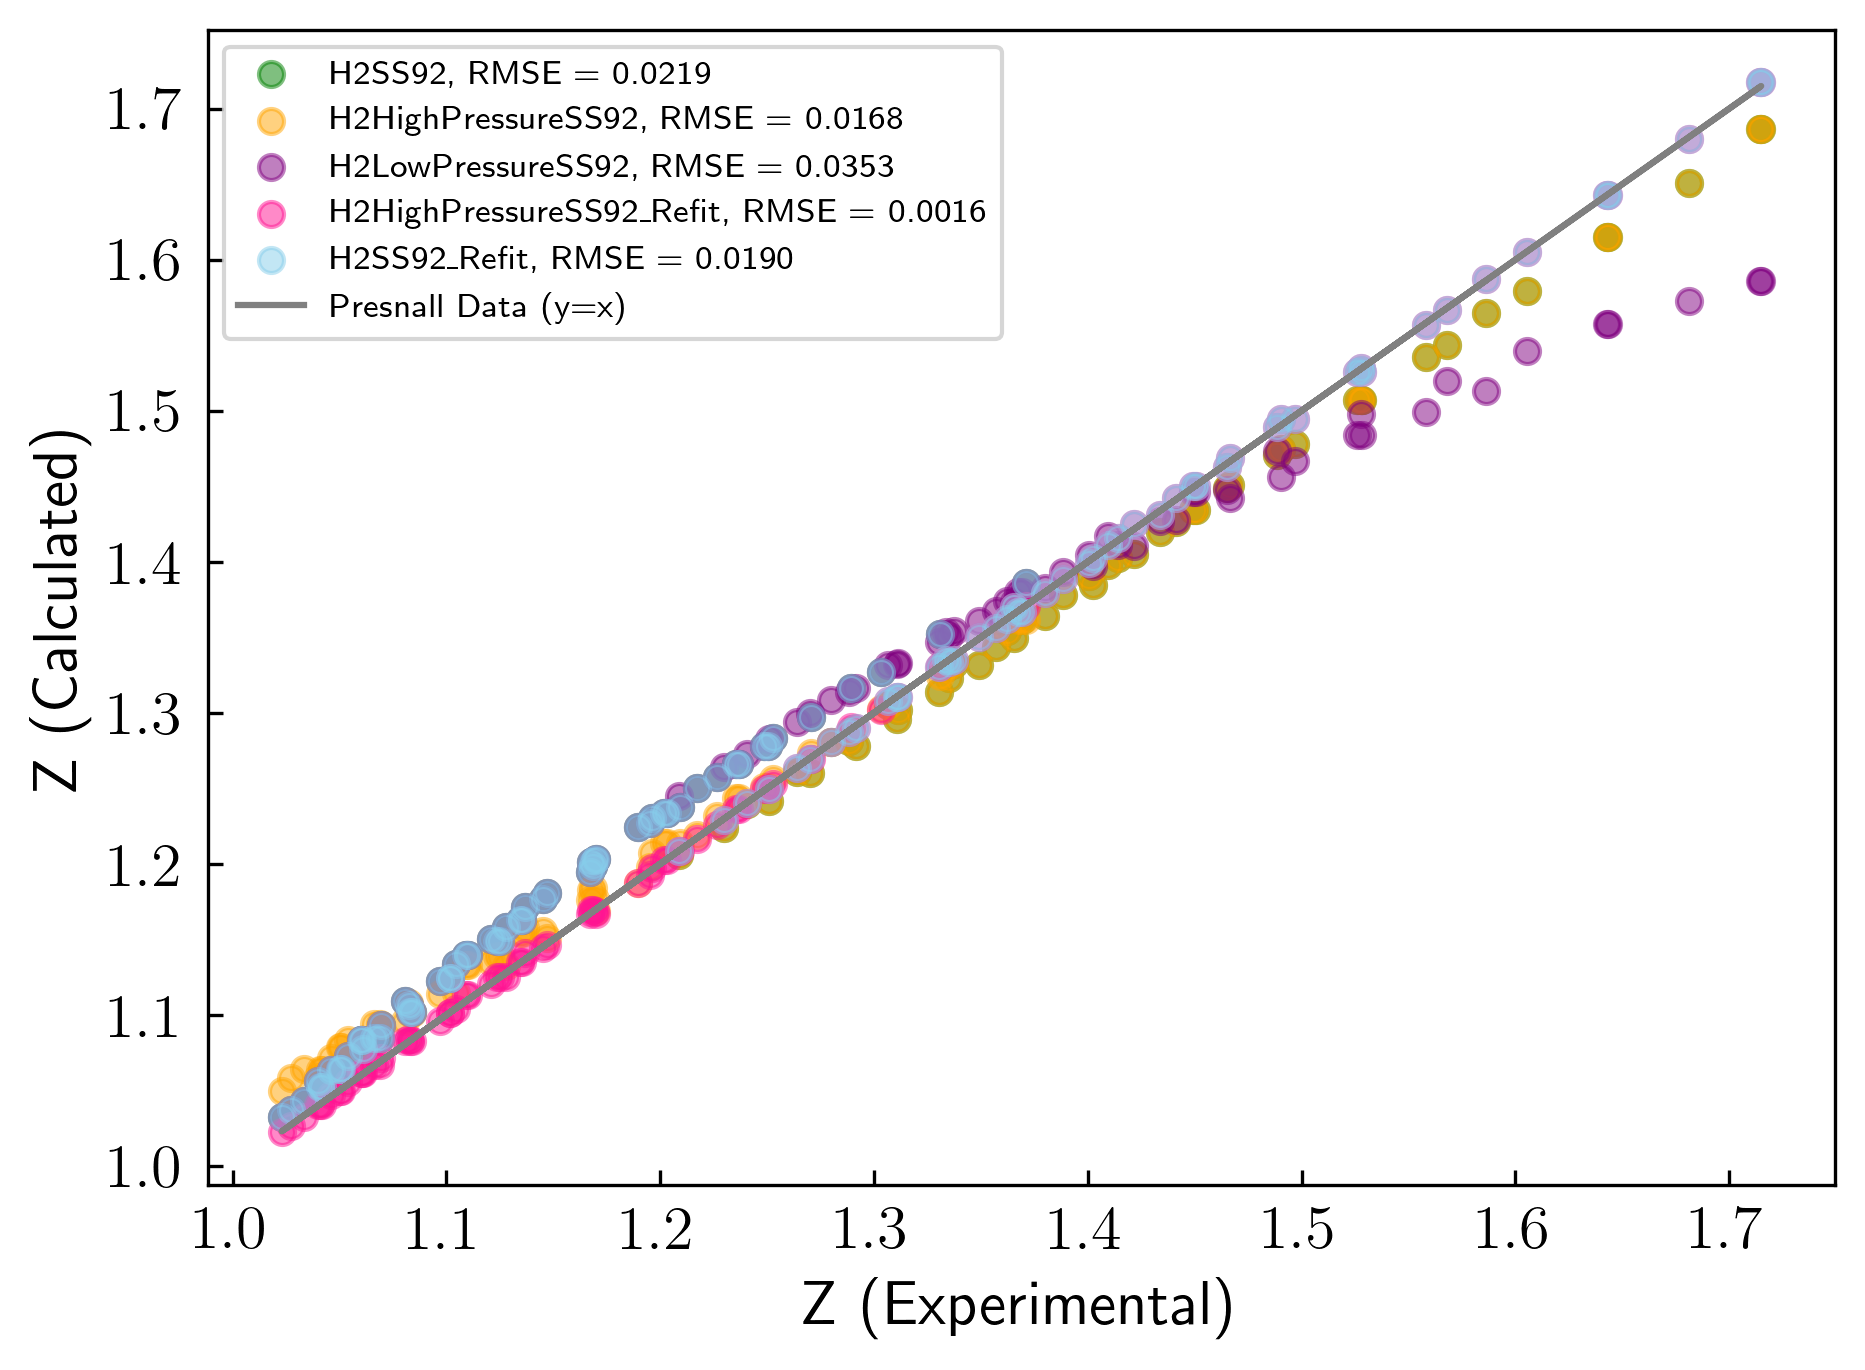

In [33]:
fig,ax = plt.subplots()
#plt.scatter(df_H2Data['Z'], Z_calc_arr_og_all, color='dodgerblue', alpha=0.5, label=r'Re-Fit to all Data')
#plt.scatter(df_H2_Presnall['Z'], df_H2_Presnall['Z'], alpha=0.3, color='gray')

#plt.scatter(df_H2_Presnall['Z'], Z_calc_arr_og_P, color='dodgerblue', alpha=0.5, label=r'Re-Fit to Data, RMSE = 0.0016')
plt.scatter(df_H2_Presnall['Z'], Z_atmodeller_arr_P, color='green', alpha=0.5, label=r'H2SS92, RMSE = 0.0219')
plt.scatter(df_H2_Presnall['Z'], Z_atmodeller_high_P, color='orange', alpha=0.5, label=r'H2HighPressureSS92, RMSE = 0.0168')
plt.scatter(df_H2_Presnall['Z'], Z_atmodeller_low_P, color='purple', alpha=0.5, label=r'H2LowPressureSS92, RMSE = 0.0353')
plt.scatter(df_H2_Presnall['Z'], Z_atmodeller_high_refit_P, color='deeppink', alpha=0.5, label=r'H2HighPressureSS92_Refit, RMSE = 0.0016')
plt.scatter(df_H2_Presnall['Z'], Z_atmodeller_refit_P, color='skyblue', alpha=0.5, label=r'H2SS92_Refit, RMSE = 0.0190')

#plt.scatter(df_H2_Presnall['Z'], Z_SF_high_P, color='skyblue', alpha=0.5, label=r'H2HighPressureSF88, RMSE = 1.373')
#plt.scatter(df_H2_Presnall['Z'], Z_SF_high_refit_P, color='teal', alpha=0.5, label=r'H2HighPressureSF88_Refit, RMSE = 0.0016')

#plt.scatter(df_H2_Presnall['Z'], Z_atmodeller_combined_P, color='deeppink', alpha=0.5, label=r'Atmodeller Combined Low and High P, RMSE = 0.0219')

plt.plot(df_H2_Presnall['Z'], df_H2_Presnall['Z'], color='gray', label='Presnall Data (y=x)')

#plt.xscale('log')
#plt.ylim(0, 7)
#plt.xlim(0, 7)
plt.xlabel('Z (Experimental)')
plt.ylabel('Z (Calculated)')
plt.legend(fontsize=8)
plt.savefig('data/Plots/ZExp_vs_ZSSModels.jpg', dpi=1000)
plt.show()

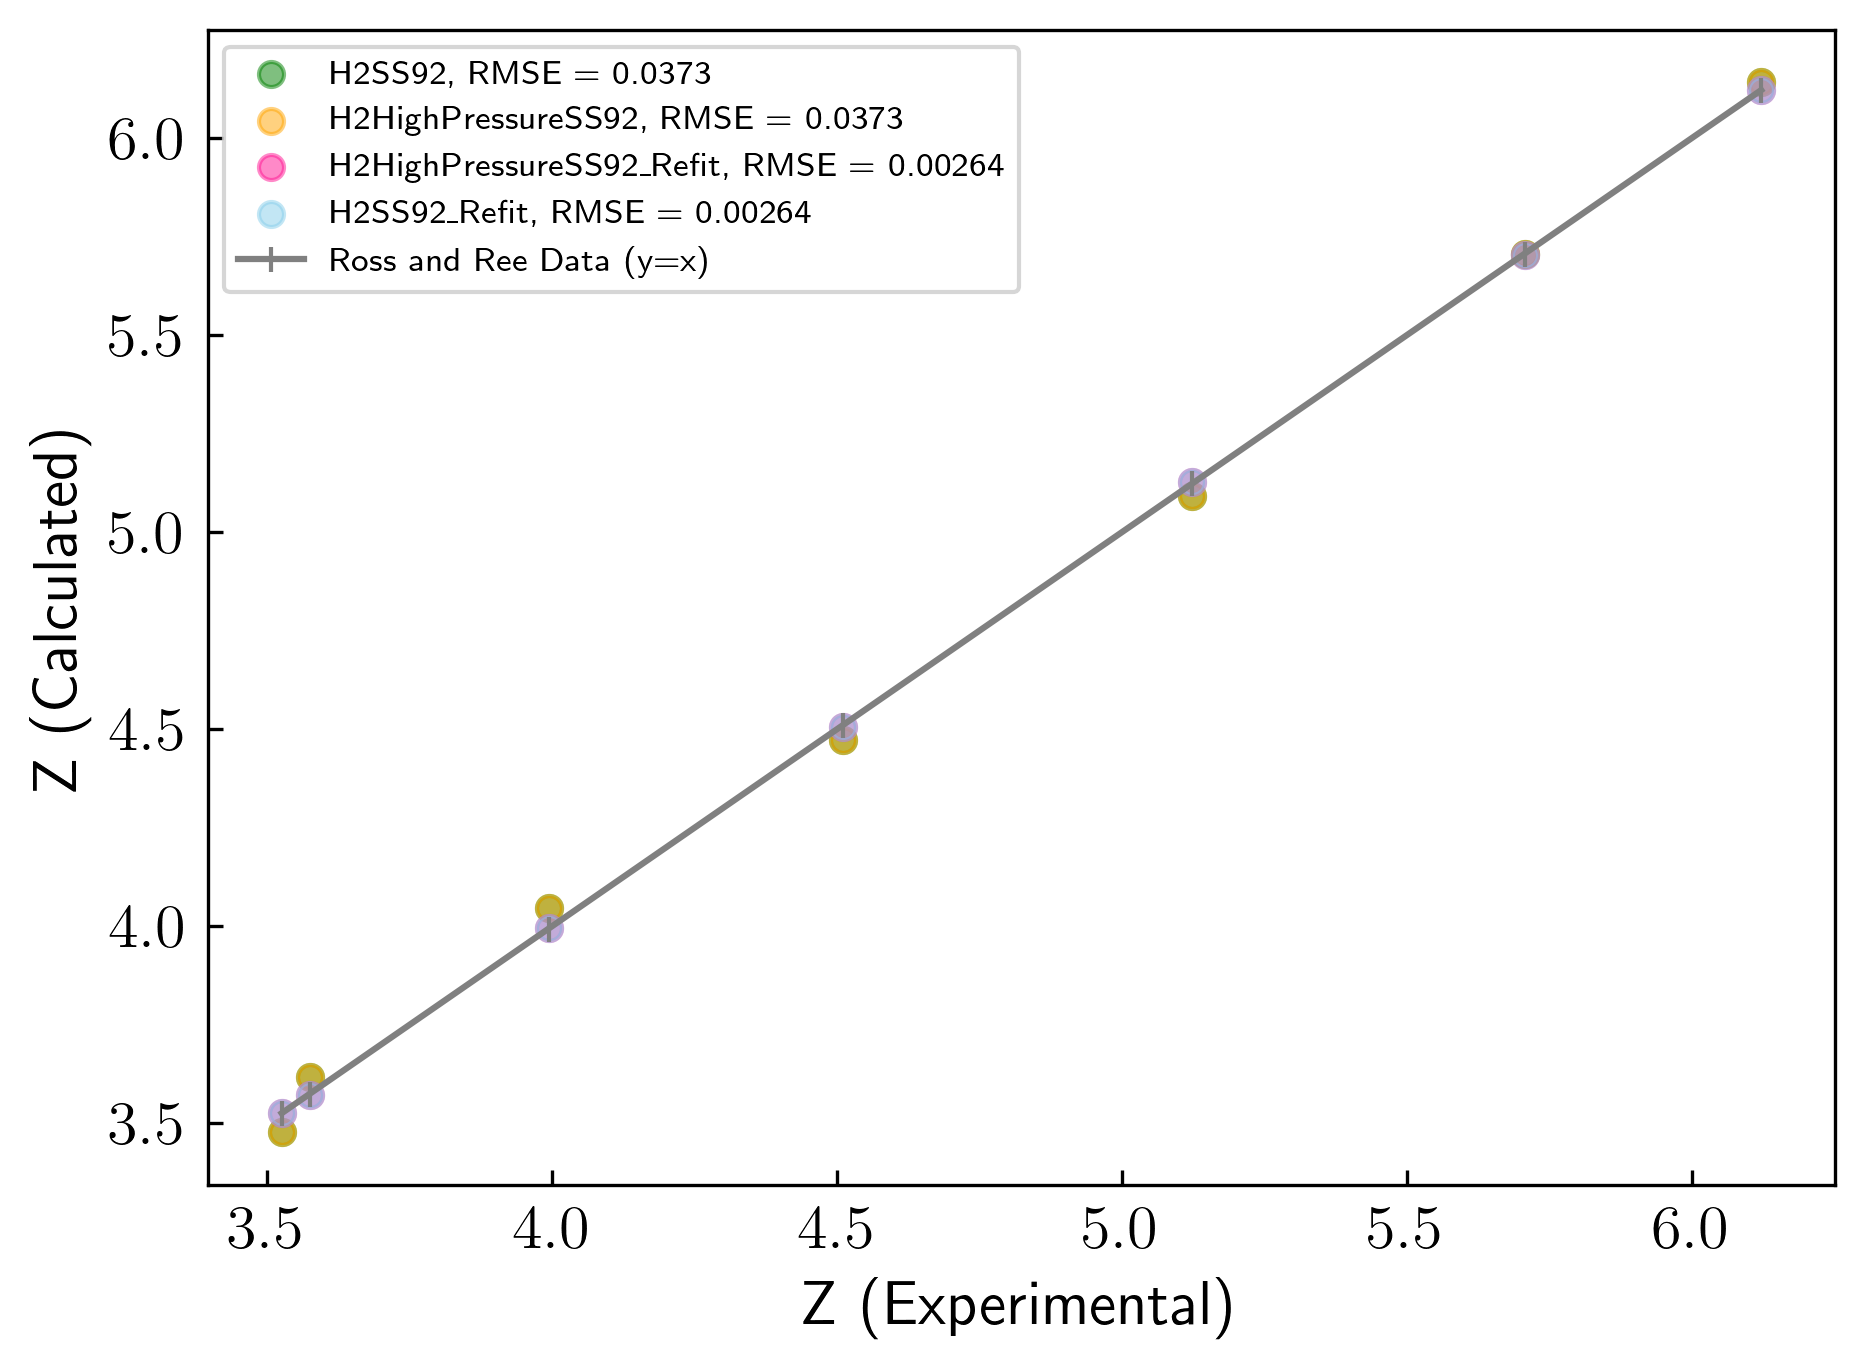

In [48]:
fig,ax = plt.subplots()
plt.scatter(df_H2_RR['Z'], Z_atmodeller_arr_RR, color='green', alpha=0.5, label=r'H2SS92, RMSE = 0.0373')
plt.scatter(df_H2_RR['Z'], Z_atmodeller_high_RR, color='orange', alpha=0.5, label=r'H2HighPressureSS92, RMSE = 0.0373')
#plt.scatter(df_H2_RR['Z'], Z_atmodeller_low_RR, color='purple', alpha=0.5, label=r'H2LowPressureSS92, RMSE = 48.28')
plt.scatter(df_H2_RR['Z'], Z_atmodeller_high_refit_RR, color='deeppink', alpha=0.5, label=r'H2HighPressureSS92_Refit, RMSE = 0.00264')
plt.scatter(df_H2_RR['Z'], Z_atmodeller_refit_RR, color='skyblue', alpha=0.5, label=r'H2SS92_Refit, RMSE = 0.00264')

#plt.scatter(df_H2_RR['Z'], df_H2_RR['Z'], color='gray', marker = '*', alpha=0.3)

plt.plot(df_H2_RR['Z'], df_H2_RR['Z'], color='gray', marker='|', label=r'Ross and Ree Data (y=x)')

#plt.xscale('log')
#plt.ylim(0, 7)
#plt.xlim(0, 7)
plt.xlabel('Z (Experimental)')
plt.ylabel('Z (Calculated)')
plt.legend(fontsize=8)
plt.savefig('data/Plots/ZExp_vs_ZSSModels_RossandRee.jpg', dpi=1000)
plt.show()

In [ ]:
#Plot Z from Data vs. Z calculated:

fig,ax = plt.subplots()
#plt.scatter(df_H2Data['Z'], Z_calc_arr_og_all, color='dodgerblue', alpha=0.5, label=r'Re-Fit to all Data')
plt.scatter(df_H2Data['Z'], df_H2Data['Z'], alpha=0.3, color='gray')

plt.scatter(df_H2Data['Z'], Z_calc_arr_og_all, color='dodgerblue', alpha=0.5, label=r'Re-Fit to Data')
plt.scatter(df_H2Data['Z'], Z_atmodeller_arr_all, color='green', alpha=0.5, label=r'Atmodeller Combined Model')
plt.scatter(df_H2Data['Z'], Z_atmodeller_high_all, color='purple', alpha=0.5, label=r'Atmodeller High-P Model only')
plt.scatter(df_H2Data['Z'], Z_atmodeller_low_all, color='orange', alpha=0.5, label=r'Atmodeller Low-P Model only')
plt.plot(df_H2Data['Z'], df_H2Data['Z'], color='gray', label='Data (y=x)')

#plt.xscale('log')
plt.ylim(0, 7)
#plt.xlim(0, 7)
plt.xlabel('Z (Experimental)')
plt.ylabel('Z (Calculated)')
#plt.legend(fontsize='small')
#plt.savefig('data/Plots/Zexp_vs_ZatmoNotReduced.jpg', dpi=1000)
plt.show()

fig,ax = plt.subplots()
plt.scatter(df_H2Data['Z'], Z_calc_arr_og_all, color='dodgerblue', alpha=0.5, label=r'Re-Fit to all Data')
plt.scatter(df_H2Data['Z'], Z_atmodeller_arr_all, color='green', alpha=0.5, label=r'Atmodeller Code')
plt.plot(df_H2Data['Z'], df_H2Data['Z'], color='gray', label='y=x')
#plt.xscale('log')
plt.xlim(1, 2)
plt.ylim(1,2)
plt.xlabel('Z (Experimental)')
plt.ylabel('Z (Calculated)')
plt.legend()
#plt.savefig('data/Plots/Zexp_vs_Zcalc_Zoom.jpg', dpi=1000)
plt.show()

In [ ]:
fig,ax = plt.subplots()
#plt.scatter(df_H2Data['Z'], Z_calc_arr_og_all, color='dodgerblue', alpha=0.5, label=r'Re-Fit to all Data')
#plt.scatter(df_H2_Presnall['Z'], df_H2_Presnall['Z'], alpha=0.3, color='gray')

plt.scatter(df_H2_Presnall['Z'], Z_calc_arr_og_P, color='dodgerblue', alpha=0.5, label=r'Re-Fit to Data, RMSE = 0.0016')
#plt.scatter(df_H2_Presnall['Z'], Z_atmodeller_arr_P, color='green', alpha=0.5, label=r'H2SS92, RMSE = 0.0219')
#plt.scatter(df_H2_Presnall['Z'], Z_atmodeller_high_P, color='orange', alpha=0.5, label=r'H2HighPressureSS92, RMSE = 0.0168')
#plt.scatter(df_H2_Presnall['Z'], Z_atmodeller_low_P, color='purple', alpha=0.5, label=r'H2LowPressureSS92, RMSE = 0.0353')
plt.scatter(df_H2_Presnall['Z'], Z_atmodeller_high_refit_P, color='deeppink', alpha=0.5, label=r'H2HighPressureSS92_Refit, RMSE = 0.0016')

#plt.scatter(df_H2_Presnall['Z'], Z_atmodeller_combined_P, color='deeppink', alpha=0.5, label=r'Atmodeller Combined Low and High P, RMSE = 0.0219')

#plt.plot(df_H2_Presnall['Z'], df_H2_Presnall['Z'], color='gray', label='Presnall Data (y=x)')

#plt.xscale('log')
#plt.ylim(0, 7)
#plt.xlim(0, 7)
plt.xlabel('Z (Experimental)')
plt.ylabel('Z (Calculated)')
plt.legend(fontsize=8)
#plt.savefig('data/Plots/Zexp_vs_Zmodelcompare.jpg', dpi=1000)
plt.show()

In [ ]:

fig,ax = plt.subplots()
plt.scatter(np.log(df_H2Data['T_K']), np.log(df_H2Data['P_GPa']*1e4), s=10, color='gray')
#plt.xscale('log')
plt.ylim(4, 12)
plt.xlim(5, 9)
plt.xlabel('ln(T)')
plt.ylabel('ln(P)')
#plt.legend(fontsize='small')
#plt.savefig('data/Plots/Data_reproduceFig2SF88.jpg', dpi=1000)
plt.show()

In [ ]:
fig,ax = plt.subplots()
plt.scatter(df_H2Data_g1kbar['P_GPa'], df_H2Data_g1kbar['Z'], color='blue', alpha=0.5, label='Data')
plt.scatter(df_H2Data_g1kbar['P_GPa'], Z_calc_arr_g1kbar, color='green', alpha=0.5, label=r'Refit to Data $>$1kbar')
plt.scatter(df_H2Data_g1kbar['P_GPa'], Z_calc_arr_og, color='orange', alpha=0.5, label=r'Fit to all Data')

#plt.scatter(df_H2Data['P_GPa']*1e4, SS_model_H2_Zarr_full, alpha=0.5, color='red', label='Z code')
#plt.scatter(P_arr_Presnall, Z_calc_arr_Presnall, alpha=0.5, color='red')
#plt.xscale('log')
plt.xlim(0.1, 0.2)
plt.ylim(1, 2)
plt.xlabel('Pressure (GPa)')
plt.ylabel('Z (compressibility factor)')
plt.legend()
plt.show()

In [ ]:
fig,ax = plt.subplots()
cs = plt.scatter(df_H2Data_g1kbar['P_GPa'], df_H2Data_g1kbar['Z'], marker='+', c=df_H2Data_g1kbar['T_K'], cmap=plt.cm.coolwarm, alpha=0.5, label='Data')
plt.scatter(df_H2Data_g1kbar['P_GPa'], Z_calc_arr_g1kbar, marker='o', c=df_H2Data_g1kbar['T_K'], cmap=plt.cm.coolwarm, alpha=0.5, label=r'Refit to Data $>$1kbar, RMSE = 0.00155')
plt.scatter(df_H2Data_g1kbar['P_GPa'], Z_calc_arr_og, marker='*', c=df_H2Data_g1kbar['T_K'], cmap=plt.cm.coolwarm, alpha=0.5, label=r'Fit to all Data, RMSE = 0.00187')
fig.colorbar(cs, label='T (K)')
#plt.scatter(df_H2Data['P_GPa']*1e4, SS_model_H2_Zarr_full, alpha=0.5, color='red', label='Z code')
#plt.scatter(P_arr_Presnall, Z_calc_arr_Presnall, alpha=0.5, color='red')
plt.xscale('log')
#plt.xlim(0.1, 0.2)
#plt.ylim(1, 2)
plt.xlabel('Pressure (GPa)')
plt.ylabel('Z (compressibility factor)')
plt.legend(fontsize='x-small')
plt.savefig('data/Plots/Z_H2_fitcomparison_rmse.jpg', dpi=1000, bbox_inches='tight')
plt.show()

fig,ax = plt.subplots()
cs = plt.scatter(df_H2Data_g1kbar['P_GPa'], df_H2Data_g1kbar['Z'], marker='+', c=df_H2Data_g1kbar['T_K'], cmap=plt.cm.coolwarm, alpha=0.5, label='Data')
plt.scatter(df_H2Data_g1kbar['P_GPa'], Z_calc_arr_g1kbar, marker='o', c=df_H2Data_g1kbar['T_K'], cmap=plt.cm.coolwarm, alpha=0.5, label=r'Refit to Data $>$1kbar, RMSE = 0.00155')
plt.scatter(df_H2Data_g1kbar['P_GPa'], Z_calc_arr_og, marker='*', c=df_H2Data_g1kbar['T_K'], cmap=plt.cm.coolwarm, alpha=0.5, label=r'Fit to all Data, RMSE = 0.00187')
fig.colorbar(cs, label='T (K)')
#plt.scatter(df_H2Data['P_GPa']*1e4, SS_model_H2_Zarr_full, alpha=0.5, color='red', label='Z code')
#plt.scatter(P_arr_Presnall, Z_calc_arr_Presnall, alpha=0.5, color='red')
#plt.xscale('log')
plt.xlim(0.1, 0.2)
plt.ylim(1, 2)
plt.xlabel('Pressure (GPa)')
plt.ylabel('Z (compressibility factor)')
plt.legend(fontsize='x-small')
#plt.savefig('data/Plots/Z_H2_fitcomparison_rmse.jpg', dpi=1000, bbox_inches='tight')
plt.show()

In [ ]:
#Isotherms:

X = np.arange(-5, 5, 0.25)
Y = np.arange(0, 5, 0.25)
X, Y = np.meshgrid(X, Y)
#print(Y)

pressure_arr = np.arange(1, 100500, 100) #bar
#print(len(pressure_arr))

T_200 = [200]*1005
T_400 = [400]*1005
T_600 = [600]*1005
T_800 = [800]*1005
T_1000 = [1000]*1005
T_1200 = [1200]*1005
T_1400 = [1400]*1005
T_1600 = [1600]*1005
T_1800 = [1800]*1005
T_2000 = [2000]*1005
T_2200 = [2200]*1005
T_2500 = [2500]*1005
T_3000 = [3000]*1005

T_arr_full = [T_200, T_400, T_600, T_800, T_1000, T_1200, T_1400, T_1600, T_1800, T_2000, T_2200, T_2500, T_3000]
print(pressure_arr)

Z_all_200 = Z_Calc_Arr(SS92_Coeffs_select, T_200, pressure_arr)
Z_all_400 = Z_Calc_Arr(SS92_Coeffs_select, T_400, pressure_arr)
Z_all_600 = Z_Calc_Arr(SS92_Coeffs_select, T_600, pressure_arr)
Z_all_800 = Z_Calc_Arr(SS92_Coeffs_select, T_800, pressure_arr)
Z_all_1000 = Z_Calc_Arr(SS92_Coeffs_select, T_1000, pressure_arr)
Z_all_1200 = Z_Calc_Arr(SS92_Coeffs_select, T_1200, pressure_arr)
Z_all_1400 = Z_Calc_Arr(SS92_Coeffs_select, T_1400, pressure_arr)
Z_all_1600 = Z_Calc_Arr(SS92_Coeffs_select, T_1600, pressure_arr)

Z_all_iso = np.array([Z_all_200, Z_all_400, Z_all_600, Z_all_800, Z_all_1000, Z_all_1200, Z_all_1400, Z_all_1600])

#Z calculated in atmodeller (fitted with all data, should be same as above):
def Z_calc_atmodeller(T, P):
    Z_atmo_arr = []
    for t,p in zip(T,P):
        Z_atmo_arr.append(SS_model_H2.compressibility_parameter(temperature=t, pressure=p))
    return Z_atmo_arr

Z_atmo_200 = Z_calc_atmodeller(T_200, pressure_arr)
Z_atmo_400 = Z_calc_atmodeller(T_400, pressure_arr)
Z_atmo_600 = Z_calc_atmodeller(T_600, pressure_arr)
Z_atmo_800 = Z_calc_atmodeller(T_800, pressure_arr)
Z_atmo_1000 = Z_calc_atmodeller(T_1000, pressure_arr)
Z_atmo_1200 = Z_calc_atmodeller(T_1200, pressure_arr)
Z_atmo_1400 = Z_calc_atmodeller(T_1400, pressure_arr)
Z_atmo_1600 = Z_calc_atmodeller(T_1600, pressure_arr)

Z_atmo_iso = np.array([Z_atmo_200, Z_atmo_400, Z_atmo_600, Z_atmo_800, Z_atmo_1000, Z_atmo_1200, Z_atmo_1400, Z_atmo_1600])
print(np.max(Z_atmo_iso))
print(Z_atmo_iso.ndim)

print(SS_model_H2.compressibility_parameter(temperature=200, pressure=100500))

In [ ]:
#%matplotlib widget

from matplotlib import cm
from matplotlib.ticker import LinearLocator


P, T = np.meshgrid(pressure_arr, np.array([200,400,600,800,1000,1200,1400,1600]))

fig, ax = plt.subplots(subplot_kw={"projection":"3d"})
surf = ax.plot_surface(P, T, Z_atmo_iso, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('Pressure (bar)')
ax.set_ylabel('Temperature (K)')
ax.set_zlabel('Z')
plt.savefig('data/Plots/Z_surfaceplot.jpg', dpi=1000)
plt.show()

fig, ax = plt.subplots(subplot_kw={"projection":"3d"})
surf = ax.plot_surface(P, T, Z_all_iso, cmap=cm.coolwarm)
fig.colorbar(surf)
plt.show()

In [ ]:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('P (GPa)')
    ax.set_zlabel('T (K)')
    ax.set_ylabel('Z')
    #ax.plot_wireframe(cParams, gammas, avg_errors_array)
    #ax.plot3D(cParams, gammas, avg_errors_array)
    ax.scatter3D(df_H2Data['P_GPa'], df_H2Data['Z'], df_H2Data['T_K'], zdir='z',cmap=cm.jet)
    #plt.xlim(0, 0.2)
    #surf = ax.plot_trisurf(df_H2Data['P_GPa'], df_H2Data['T_K'], df_H2Data['Z'], cmap=cm.jet, linewidth=0.1)
    #fig.colorbar(surf, shrink=0.5, aspect=5)    
    plt.savefig('data/Plots/H2_Data_3Dscatter.jpg', dpi=1000, bbox_inches='tight')
    plt.show()

  

In [ ]:
fig,ax = plt.subplots()
plt.scatter(df_H2Data['P_GPa'], df_H2Data['Z'], color='blue', alpha=0.5, label='Data')
plt.scatter(df_H2Data['P_GPa'], Z_calc_arr_g1kbar_all, color='green', alpha=0.5, label=r'Refit to Data $>$1kbar')
plt.scatter(df_H2Data['P_GPa'], Z_calc_arr_og_all, color='orange', alpha=0.5, label=r'Fit to all Data')
plt.scatter(df_H2Data['P_GPa'], Z_atmodeller_arr_all, color='deeppink', alpha=0.5, label=r'Atmodeller Code')

#plt.scatter(df_H2Data['P_GPa']*1e4, SS_model_H2_Zarr_full, alpha=0.5, color='red', label='Z code')
#plt.scatter(P_arr_Presnall, Z_calc_arr_Presnall, alpha=0.5, color='red')
plt.xscale('log')
#plt.xlim(0.1, 0.2)
#plt.ylim(1, 2)
plt.xlabel('Pressure (GPa)')
plt.ylabel('Z (compressibility factor)')
plt.legend()
plt.show()

### Holland & Powell Model

In [8]:
models = get_holland_fugacity_models()
# list the available species

HP_model = models['H2']
H2_fug_coeff = HP_model.get_value(temperature=2000, pressure=1000)
print(H2_fug_coeff)

1.1665464286975995


### Kite et al.2019 (Derived from Saumon et al. 1995 Tables)

In [9]:
#Data extracted from Figure 2 a
Kite_datafile_2000: str = f"data/solubility_data/H2/Kite_H2FugCoeff_2000K.csv"
K19_2000_df: pd.DataFrame = pd.read_csv(Kite_datafile_2000, names=('P_GPa', 'H2_fc'))

Kite_datafile_1673: str = f"data/solubility_data/H2/Kite_H2FugCoeff_1673K.csv"
K19_1673_df: pd.DataFrame = pd.read_csv(Kite_datafile_1673, names=('P_GPa', 'H2_fc'))

Kite_datafile_2500: str = f"data/solubility_data/H2/Kite_H2FugCoeff_2500K.csv"
K19_2500_df: pd.DataFrame = pd.read_csv(Kite_datafile_2500, names=('P_GPa', 'H2_fc'))

print(K19_2000_df)

        P_GPa       H2_fc
0    0.026826    0.985848
1    0.363343    1.254300
2    0.868118    1.762095
3    1.356067    2.372226
4    1.810365    3.104358
5    2.466573    4.485279
6    3.005000    6.037598
7    3.577079    8.011825
8    4.098680   10.482814
9    4.721236   14.108016
10   5.377444   19.257157
11   5.932697   24.838827
12   6.353343   30.277315
13   7.228287   43.722957
14   7.783539   55.600103
15   8.389270   71.707155
16   9.112781   97.863189
17   9.668034  120.959437
18  10.004551  137.356281


In [ ]:
#Calculations of phi from Equation 2 and Saumon Tables

KS_1995_file: str = f"data/solubility_data/H2/H2_KiteSaumon_1995K.csv"
KS_1995_df: pd.DataFrame = pd.read_csv(KS_1995_file, skiprows=2, names=('logP', 'P_GPa', 'P_bar','XH2', 'XH', 'log_rho', 'rho', 'Vm', 'log_S', 'log_U', 'dlogrho_dlogT_P', 'dlogrho_dlogP_T', 
'dlogS_dlogT_P', 'dlogS_dlogP_T', 'dlogT_dlogP_S', 'ln_phi', 'phi'))

KS_2398_file: str = f"data/solubility_data/H2/H2_KiteSaumon_2398K.csv"
KS_2398_df: pd.DataFrame = pd.read_csv(KS_2398_file, skiprows=2, names=('logP', 'P_GPa', 'P_bar','XH2', 'XH', 'log_rho', 'rho', 'Vm', 'log_S', 'log_U', 'dlogrho_dlogT_P', 'dlogrho_dlogP_T', 
'dlogS_dlogT_P', 'dlogS_dlogP_T', 'dlogT_dlogP_S', 'Z', 'Int', 'phi'))

KS_2884_file: str = f"data/solubility_data/H2/H2_KiteSaumon_2884K.csv"
KS_2884_df: pd.DataFrame = pd.read_csv(KS_2884_file, skiprows=2, names=('logP', 'P_GPa', 'P_bar','XH2', 'XH', 'log_rho', 'rho', 'Vm', 'log_S', 'log_U', 'dlogrho_dlogT_P', 'dlogrho_dlogP_T', 
'dlogS_dlogT_P', 'dlogS_dlogP_T', 'dlogT_dlogP_S', 'Z', 'Int', 'phi'))

KS_1660_file: str = f"data/solubility_data/H2/H2_KiteSaumon_1660K.csv"
KS_1660_df: pd.DataFrame = pd.read_csv(KS_1660_file, skiprows=2, names=('logP', 'P_GPa', 'P_bar','XH2', 'XH', 'log_rho', 'rho', 'Vm', 'log_S', 'log_U', 'dlogrho_dlogT_P', 'dlogrho_dlogP_T', 
'dlogS_dlogT_P', 'dlogS_dlogP_T', 'dlogT_dlogP_S', 'Z', 'Int', 'phi'))

print(KS_1995_df)

In [ ]:
#Calculationg of phi (attempt #2) using trapz method (but not sure I've done so correctly)
KS_1995_file_2: str = f"data/solubility_data/H2/H2_KiteSaumon_1995K_v2.csv"
KS_1995_df_2: pd.DataFrame = pd.read_csv(KS_1995_file_2, skiprows=2, names=('logP', 'P_GPa', 'P_bar','XH2', 'XH', 'log_rho', 'rho', 'Vm', 'log_S', 'log_U', 'dlogrho_dlogT_P', 'dlogrho_dlogP_T', 
'dlogS_dlogT_P', 'dlogS_dlogP_T', 'dlogT_dlogP_S', 'Z', 'Z-1_P', 'Int', 'phi'))

KS_2398_file_2: str = f"data/solubility_data/H2/H2_KiteSaumon_2398K_v2.csv"
KS_2398_df_2: pd.DataFrame = pd.read_csv(KS_2398_file_2, skiprows=2, names=('logP', 'P_GPa', 'P_bar','XH2', 'XH', 'log_rho', 'rho', 'Vm', 'log_S', 'log_U', 'dlogrho_dlogT_P', 'dlogrho_dlogP_T', 
'dlogS_dlogT_P', 'dlogS_dlogP_T', 'dlogT_dlogP_S', 'Z', 'Z-1_P', 'Int', 'phi'))

KS_2884_file_2: str = f"data/solubility_data/H2/H2_KiteSaumon_2884K_v2.csv"
KS_2884_df_2: pd.DataFrame = pd.read_csv(KS_2884_file_2, skiprows=2, names=('logP', 'P_GPa', 'P_bar','XH2', 'XH', 'log_rho', 'rho', 'Vm', 'log_S', 'log_U', 'dlogrho_dlogT_P', 'dlogrho_dlogP_T', 
'dlogS_dlogT_P', 'dlogS_dlogP_T', 'dlogT_dlogP_S', 'Z', 'Z-1_P', 'Int', 'phi'))

KS_1660_file_2: str = f"data/solubility_data/H2/H2_KiteSaumon_1660K_v2.csv"
KS_1660_df_2: pd.DataFrame = pd.read_csv(KS_1660_file_2, skiprows=2, names=('logP', 'P_GPa', 'P_bar','XH2', 'XH', 'log_rho', 'rho', 'Vm', 'log_S', 'log_U', 'dlogrho_dlogT_P', 'dlogrho_dlogP_T', 
'dlogS_dlogT_P', 'dlogS_dlogP_T', 'dlogT_dlogP_S', 'Z', 'Z-1_P', 'Int', 'phi'))

print(KS_1995_df_2)

### Looping over temperature and pressure

In [10]:
pressure_arr = np.arange(0.01, 100500, 100)
temp_arr = np.arange(470, 890, 10)

temp_arr_SF = np.arange(273, 2093, 50)
temp_arr_SF_hi = np.arange(273, 3090, 50)

temp_arr_2000 = [2000]*1005
print(len(pressure_arr))
print(len(temp_arr_2000))

1005
1005


In [11]:
def fugacitycoeff_func(model, temperature, pressure_range):
    model_arr = []
    for p in pressure_range:
        fug_val = model.get_value(temperature=temperature, pressure=p)
        model_arr.append(fug_val)
    return model_arr

def fugacitycoeff_func_T(model, temperature_range, pressure):
    model_arr = []
    for t in temperature_range:
        fug_val = model.get_value(temperature=t, pressure=pressure)
        model_arr.append(fug_val)
    return model_arr

def fugacitycoeff_func_PT(model, temperature_range, pressure_range):
    model_arr = []
    for t,p in zip(temperature_range, pressure_range):
        fug_val = model.get_value(temperature=t, pressure=p)
        model_arr.append(fug_val)
    return model_arr


def volume_func(model, temperature_range, pressure):
    model_arr = []
    for t in temperature_range:
        vol_val = model.volume(temperature=t, pressure=pressure)
        vol_val_units = vol_val*10 #Units, multiplying by 10 to convert J/bar/mol to cm^3/mol
        model_arr.append(vol_val_units)
    return model_arr

def volume_func_2(model, temperature_range, pressure_range):
    model_arr = []
    for t,p in zip(temperature_range, pressure_range):
        vol_val = model.volume(temperature=t, pressure=p)
        vol_val_units = vol_val*10 #Units, multiplying by 10 to convert J/bar/mol to cm^3/mol
        model_arr.append(vol_val_units)
    return model_arr

#### Holland & Powell Models

In [12]:
HP_2000 = fugacitycoeff_func(HP_model, 2000, pressure_arr)
HP_2500 = fugacitycoeff_func(HP_model, 2500, pressure_arr)
HP_1673 = fugacitycoeff_func(HP_model, 1673, pressure_arr)
HP_473 = fugacitycoeff_func(HP_model, 473, pressure_arr)
HP_873 = fugacitycoeff_func(HP_model, 873, pressure_arr)

#### Saxena Models


In [ ]:
#Load models from Excel:
H2_HighP_MyIntCalc: str = f"data/FugacityCoeff_FittingData/H2_HighPressureData_Int.csv"
df_H2_MyIntCalc: pd.DataFrame = pd.read_csv(H2_HighP_MyIntCalc, skiprows=1, names=('V_cm3mol', 'P_GPa', 'P_bar', 'T_K', 'V_ideal', 'V-Videal', 'Int', 'Phi'))

H2_PS_Presnall: str = f"data/FugacityCoeff_FittingData/Paolo_PresnallData.csv"
df_H2_PS_Presnall: pd.DataFrame = pd.read_csv(H2_PS_Presnall, skiprows=1, names=('P_bar', 'T_K', 'Phi_calc', 'Phi_published'))

H2_PS_RR: str = f"data/FugacityCoeff_FittingData/Paolo_RossRee.csv"
df_H2_PS_RR: pd.DataFrame = pd.read_csv(H2_PS_RR, skiprows=1, names=('P_bar', 'T_K', 'Phi'))

In [13]:
T_arr_Presnall = [873.15]*9
P_arr_Presnall = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800]

P_arr_RR = [1, 9670, 15730, 25630, 41660, 66880, 107200, 114540]
T_arr_RR = [20.35, 266, 431, 722, 1222, 2014, 3246, 3462]

In [29]:
SS_model_RR =  fugacitycoeff_func_PT(SS_model_H2, T_arr_RR, P_arr_RR)
SS_calc_RR = fug_coeff_eq11_arr(SS92_Coeffs_select, T_arr_RR, P_arr_RR, 1)

SS_model_Presnall = fugacitycoeff_func_PT(SS_model_H2, T_arr_Presnall, P_arr_Presnall)
SS_calc_Presnall = fug_coeff_eq11_arr(SS92_Coeffs_select, T_arr_Presnall, P_arr_Presnall, 1)

print('Presnall Data Fit Comparisons:')
print(r'Shi & Saxena in Code:')
print(SS_model_Presnall)
print(r'Int Calculation V-Videal:')
print(phi_calc_allinone_arr_P)
print(r'Calculation with eq. 11 (should be same as in code):')
print(SS_calc_Presnall)
#print('')
#print(SS_model_H2.get_value(temperature=873.15, pressure=400))

Presnall Data Fit Comparisons:
Shi & Saxena in Code:
[1.0578963944436537, 1.1174389463545589, 1.1781950741361498, 1.2400047061894475, 1.396486500827831, 1.4537930717538063, 1.512405515513496, 1.5725551488669387, 1.6344138516455657]
Int Calculation V-Videal:


NameError: name 'phi_calc_allinone_arr_P' is not defined

## Plots

### H2 Fugacity Coefficient

In [ ]:
#Plotting H2 Phi for Presnall Data and Models:

fig, ax = plt.subplots()
plt.plot(df_H2_PS_Presnall.P_bar, df_H2_PS_Presnall.Phi_published, alpha=0.5, color='red', label='Presnall Published')
plt.plot(df_H2_MyIntCalc.P_bar[100:118], df_H2_MyIntCalc.Phi[100:118], alpha=0.5, color='dodgerblue', label='My Integral Calculation')
plt.plot(df_H2_PS_Presnall.P_bar, df_H2_PS_Presnall.Phi_calc, alpha=0.5, color = 'green', label='Paolo Presnall Calculation')
plt.plot(P_arr_Presnall, SS_model_Presnall, alpha=0.5, color='orange', label='Model in the Code')
plt.plot(P_arr_Presnall, phi_calc_allinone_arr_P, alpha=0.5, color='purple', label='Integral Calculation from Z fit')

plt.scatter(df_H2_PS_Presnall.P_bar, df_H2_PS_Presnall.Phi_published, color='red')
plt.scatter(df_H2_MyIntCalc.P_bar[100:118], df_H2_MyIntCalc.Phi[100:118], color='dodgerblue')
plt.scatter(df_H2_PS_Presnall.P_bar, df_H2_PS_Presnall.Phi_calc,  color = 'green')
plt.scatter(P_arr_Presnall, SS_model_Presnall, color='orange')
plt.scatter(P_arr_Presnall, phi_calc_allinone_arr_P, color='purple')

plt.legend(fontsize=10)
plt.xlabel('Pressure (bar)')
plt.ylabel(r'H$_2$ $\phi$')
#plt.savefig('data/Plots/PresnallComparison.jpg', dpi=1000)
plt.show()


In [ ]:
print(df_H2_MyIntCalc.Phi[0:8])

In [ ]:
#Plotting Ross and Ree Comparison between Data and various Models:

fig, ax = plt.subplots()
plt.plot(df_H2_MyIntCalc.P_bar[0:8]/1e4, df_H2_MyIntCalc.Phi[0:8], alpha=0.5, color='dodgerblue', label='Integral Calculation (Data Only)')
plt.plot(df_H2_PS_RR.P_bar/1e4, df_H2_PS_RR.Phi, alpha=0.5, color = 'green', label=r'Paolo Ross \& Ree Calculation')
plt.plot(np.array(P_arr_RR)/1e4, SS_model_RR, alpha=0.5, color='orange', label='Model in the Code')
#plt.plot(np.array(P_arr_RR)/1e4, SS_calc_RR, alpha=0.5, color='purple', label='My Model Calculation')
plt.plot(np.array(P_arr_RR)/1e4, phi_calc_allinone_arr_RR, alpha=0.5, color='deeppink', linestyle='--', label='Integral Calculation from Z fit')

plt.scatter(df_H2_MyIntCalc.P_bar[0:10]/1e4, df_H2_MyIntCalc.Phi[0:10], alpha=0.3, color='dodgerblue')
plt.scatter(df_H2_PS_RR.P_bar/1e4, df_H2_PS_RR.Phi, alpha=0.3, color = 'green')
plt.scatter(np.array(P_arr_RR)/1e4, SS_model_RR, alpha=0.3, color='orange')
#plt.scatter(np.array(P_arr_RR)/1e4, SS_calc_RR, alpha=0.3, color='purple')
plt.scatter(np.array(P_arr_RR)/1e4, phi_calc_allinone_arr_RR, alpha=0.3, color='deeppink')

plt.legend(fontsize=10)
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'H$_2$ $\phi$')
#plt.savefig('data/Plots/RossReeComparison_OnlyGoodOnes.jpg', dpi=1000)
plt.show()

In [15]:
SS_1673 = fugacitycoeff_func(SS_model_H2, 1673, pressure_arr)
SS_2000 = fugacitycoeff_func(SS_model_H2, 2000, pressure_arr)
SS_2500 = fugacitycoeff_func(SS_model_H2, 2500, pressure_arr)
SS_6000 = fugacitycoeff_func(SS_model_H2, 6000, pressure_arr)

SS_2000_refit = fugacitycoeff_func(SS_model_hi_refit, 2000, pressure_arr)

SS_2000_refit_full = fugacitycoeff_func(SS_model_H2_refit, 2000, pressure_arr)

In [ ]:
temp_arr_SF = np.arange(273, 2093, 50)
temp_arr_SF_hi = np.arange(273, 3090, 50)


SS_model_5bar = volume_func(SS_model_lo, temp_arr_SF, 5)
SS_model_10bar = volume_func(SS_model_lo, temp_arr_SF, 10)
SS_model_25bar = volume_func(SS_model_lo, temp_arr_SF, 25)
SS_model_50bar = volume_func(SS_model_lo, temp_arr_SF, 50)
SS_model_100bar = volume_func(SS_model_lo, temp_arr_SF, 100)

SS_model_200bar = volume_func(SS_model_lo, temp_arr_SF, 200)
SS_model_300bar = volume_func(SS_model_lo, temp_arr_SF, 300)
SS_model_400bar = volume_func(SS_model_lo, temp_arr_SF, 400)
SS_model_500bar = volume_func(SS_model_lo, temp_arr_SF, 500)
SS_model_600bar = volume_func(SS_model_lo, temp_arr_SF, 600)
SS_model_700bar = volume_func(SS_model_lo, temp_arr_SF, 700)
SS_model_800bar = volume_func(SS_model_lo, temp_arr_SF, 800)
SS_model_900bar = volume_func(SS_model_lo, temp_arr_SF, 900)
SS_model_1000bar = volume_func(SS_model_lo, temp_arr_SF, 1000)

SS_model_1000bar_hi = volume_func(SS_model_hi, temp_arr_SF_hi, 1000)
SS_model_2000bar = volume_func(SS_model_hi, temp_arr_SF_hi, 2000)
SS_model_3000bar = volume_func(SS_model_hi, temp_arr_SF_hi, 3000)
SS_model_4000bar = volume_func(SS_model_hi, temp_arr_SF_hi, 4000)
SS_model_5000bar = volume_func(SS_model_hi, temp_arr_SF_hi, 5000)
SS_model_6000bar = volume_func(SS_model_hi, temp_arr_SF_hi, 6000)
SS_model_8000bar = volume_func(SS_model_hi, temp_arr_SF_hi, 8000)
SS_model_10000bar = volume_func(SS_model_hi, temp_arr_SF_hi, 10000)


SS_model_1000bar_lo = volume_func(SS_model_lo, temp_arr_SF_hi, 1000)
SS_model_2000bar_lo = volume_func(SS_model_lo, temp_arr_SF_hi, 2000)
SS_model_3000bar_lo = volume_func(SS_model_lo, temp_arr_SF_hi, 3000)
SS_model_4000bar_lo = volume_func(SS_model_lo, temp_arr_SF_hi, 4000)
SS_model_5000bar_lo = volume_func(SS_model_lo, temp_arr_SF_hi, 5000)
SS_model_6000bar_lo = volume_func(SS_model_lo, temp_arr_SF_hi, 6000)
SS_model_8000bar_lo = volume_func(SS_model_lo, temp_arr_SF_hi, 8000)
SS_model_10000bar_lo = volume_func(SS_model_lo, temp_arr_SF_hi, 10000)

print(len(SS_model_5bar))

In [ ]:
SF_model_1000bar = volume_func(SF_model_hi, temp_arr_SF_hi, 1000)
SF_model_2000bar = volume_func(SF_model_hi, temp_arr_SF_hi, 2000)
SF_model_3000bar = volume_func(SF_model_hi, temp_arr_SF_hi, 3000)
SF_model_4000bar = volume_func(SF_model_hi, temp_arr_SF_hi, 4000)
SF_model_5000bar = volume_func(SF_model_hi, temp_arr_SF_hi, 5000)
SF_model_6000bar = volume_func(SF_model_hi, temp_arr_SF_hi, 6000)
SF_model_8000bar = volume_func(SF_model_hi, temp_arr_SF_hi, 8000)
SF_model_10000bar = volume_func(SF_model_hi, temp_arr_SF_hi, 10000)

print(SF_model_1000bar)
print(SF_model_10000bar)

In [ ]:
SS_2000_intcalc = fug_coeff_fromV_Zfit_arr(SS92_Coeffs_select, temp_arr_2000, pressure_arr, 1)

print(SS_2000_intcalc)


### Comparing H2 Fugacity Coefficient Shi & Saxena, Holland & Powell, Kite 

In [ ]:
fig,ax = plt.subplots()
plt.plot(pressure_arr/1e4, HP_2000, color='dodgerblue',  label=r'2000 K, Holland \& Powell')

plt.plot(pressure_arr/1e4, SS_2000, color='forestgreen', alpha=0.5,  label=r'2000 K, Shi \& Saxena')
#plt.plot(pressure_arr/1e4, SS_2000_intcalc, color='deeppink', alpha=0.5, label=r'2000 K, Shi \& Saxena Integral Calc')

plt.plot(K19_2000_df['P_GPa'], K19_2000_df['H2_fc'], color='purple', label=r'2000 K, Kite et al. 2019')
plt.axvline(x=0.18, color='gray', alpha=0.5, linestyle='--')
plt.legend(fontsize=8)
plt.ylim(0, 60)
plt.xlim(-0.01, 10)
#plt.xscale('log')
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'$H_2$ Fugacity Coefficient')
#plt.savefig('data/Plots/H2_FugacityCoefficients_SSvsHPvsKite.jpg', dpi=1000)
plt.show()



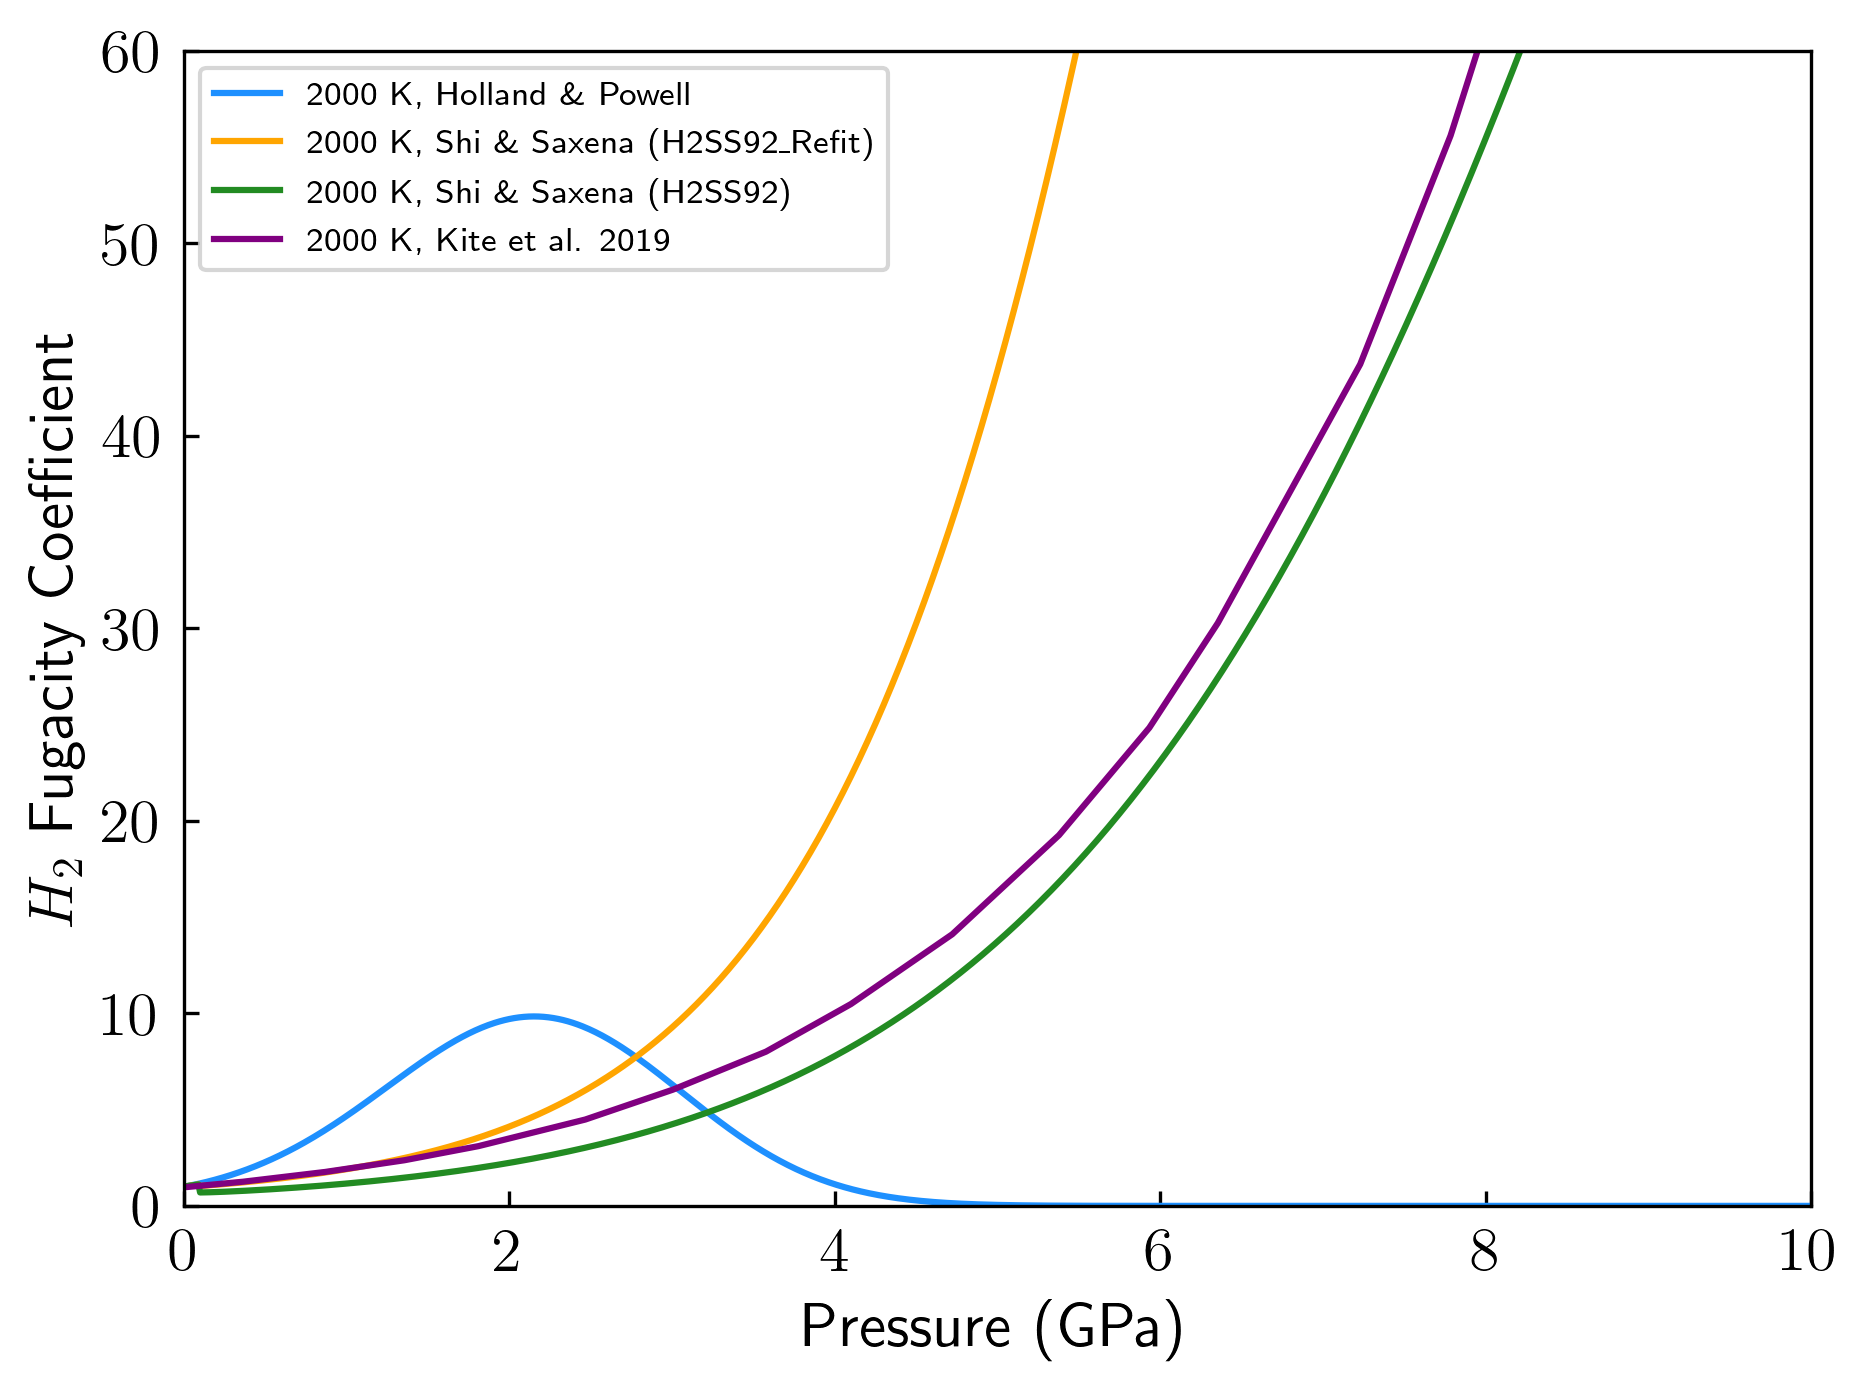

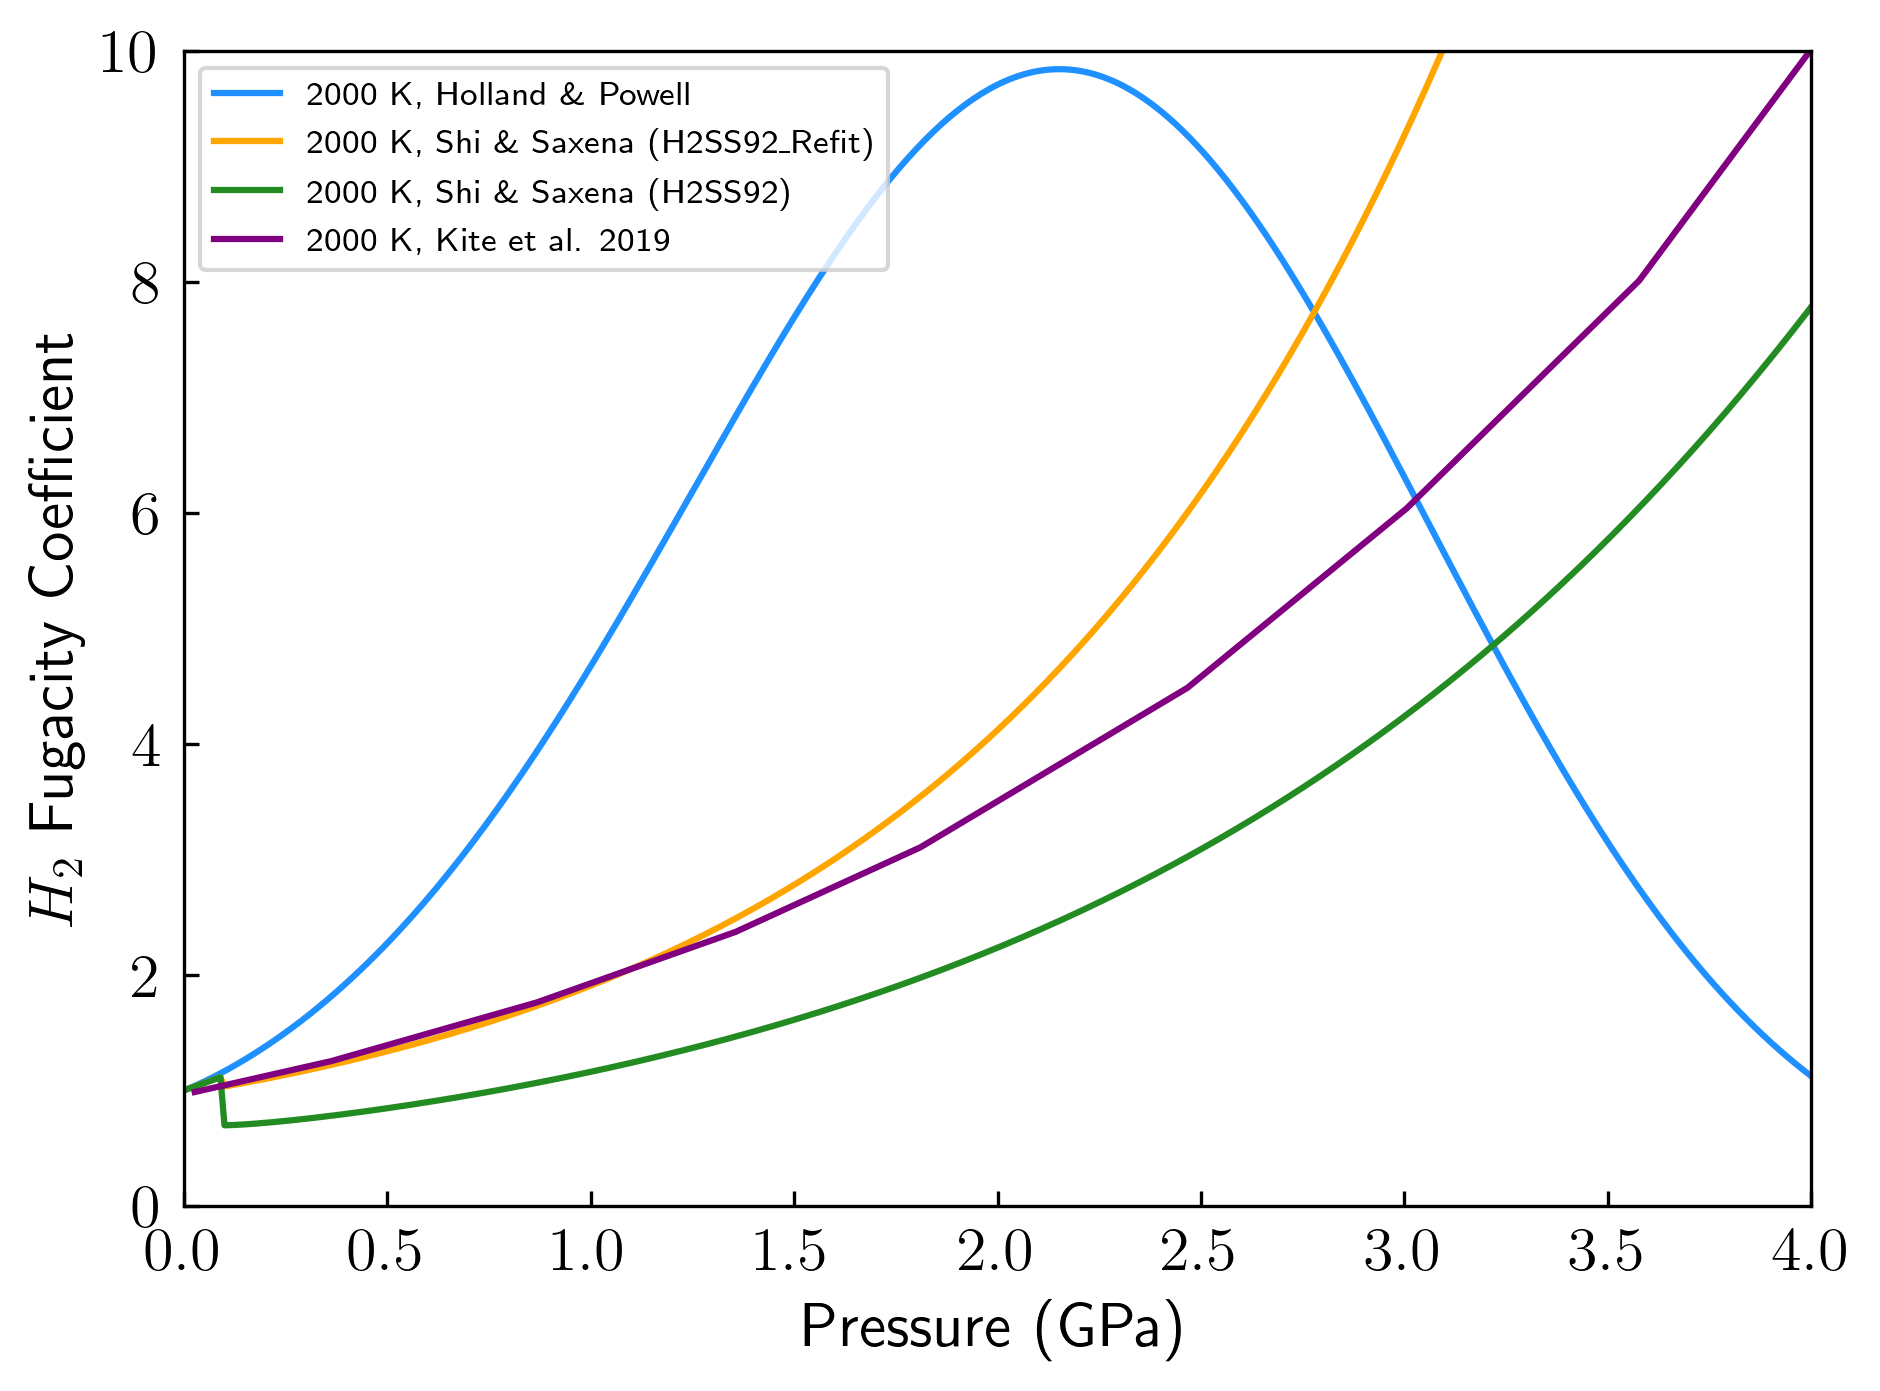

In [34]:
fig,ax = plt.subplots()
plt.plot(pressure_arr/1e4, HP_2000, color='dodgerblue',  label=r'2000 K, Holland \& Powell')

plt.plot(pressure_arr/1e4, SS_2000_refit_full, color='orange',  label=r'2000 K, Shi \& Saxena (H2SS92_Refit)')
plt.plot(pressure_arr/1e4, SS_2000, color='forestgreen', label=r'2000 K, Shi \& Saxena (H2SS92)')

#plt.plot(pressure_arr/1e4, SS_2000_intcalc, color='deeppink', alpha=0.5, label=r'2000 K, Shi \& Saxena Integral Calc')

plt.plot(K19_2000_df['P_GPa'], K19_2000_df['H2_fc'], color='purple', label=r'2000 K, Kite et al. 2019')
#plt.axvline(x=0.18, color='gray', linestyle='--')
plt.legend(fontsize=8)
plt.ylim(0, 60)
#plt.yscale('log')
plt.xlim(0, 10)
#plt.xscale('log')
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'$H_2$ Fugacity Coefficient')
plt.savefig('data/Plots/H2_FugacityCoefficients_SSvsSSRefitvsHPvsKite.jpg', dpi=1000)
plt.show()

fig,ax = plt.subplots()
plt.plot(pressure_arr/1e4, HP_2000, color='dodgerblue',  label=r'2000 K, Holland \& Powell')

plt.plot(pressure_arr/1e4, SS_2000_refit_full, color='orange',  label=r'2000 K, Shi \& Saxena (H2SS92_Refit)')
plt.plot(pressure_arr/1e4, SS_2000, color='forestgreen', label=r'2000 K, Shi \& Saxena (H2SS92)')

#plt.plot(pressure_arr/1e4, SS_2000_intcalc, color='deeppink', alpha=0.5, label=r'2000 K, Shi \& Saxena Integral Calc')

plt.plot(K19_2000_df['P_GPa'], K19_2000_df['H2_fc'], color='purple', label=r'2000 K, Kite et al. 2019')
#plt.axvline(x=0.18, color='gray', linestyle='--')
plt.legend(fontsize=8)
plt.ylim(0, 10)
#plt.yscale('log')
plt.xlim(0, 4)
#plt.xscale('log')
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'$H_2$ Fugacity Coefficient')
plt.savefig('data/Plots/H2_FugacityCoefficients_SSvsSSRefitvsHPvsKite_Zoom.jpg', dpi=1000)
plt.show()

In [ ]:
fig,ax = plt.subplots()
plt.plot(pressure_arr/1e4, HP_1673, color='dodgerblue', linestyle='dotted', label=r'1673 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000, color='dodgerblue', linestyle='--', label=r'2000 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2500, color='dodgerblue', label=r'2500 K, Holland \& Powell')

plt.plot(pressure_arr/1e4, SS_1673, color='forestgreen', linestyle='dotted', label=r'1673 K, Shi \& Saxena')
plt.plot(pressure_arr/1e4, SS_2000, color='forestgreen', linestyle='--', label=r'2000 K, Shi \& Saxena')
plt.plot(pressure_arr/1e4, SS_2500, color='forestgreen', label=r'2500 K, Shi \& Saxena')
#plt.plot(pressure_arr/1e4, SS_6000, color='limegreen', label=r'6000 K, Shi \& Saxena')

plt.plot(K19_1673_df['P_GPa'], K19_1673_df['H2_fc'], color='purple', linestyle='dotted', label=r'1673 K, Kite et al. 2019')
plt.plot(K19_2000_df['P_GPa'], K19_2000_df['H2_fc'], color='purple', linestyle='--', label=r'2000 K, Kite et al. 2019')
plt.plot(K19_2500_df['P_GPa'], K19_2500_df['H2_fc'], color='purple', label=r'2500 K, Kite et al. 2019')
plt.axvline(x=0.18, color='gray', alpha=0.5, linestyle='--')
plt.legend(fontsize=8)
plt.ylim(0, 60)
plt.xlim(-0.01, 10)
#plt.xscale('log')
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'$H_2$ Fugacity Coefficient')
#plt.savefig('data/Plots/H2_FugacityCoefficients_KitevsShiSaxena2.jpg', dpi=1000)
plt.show()

In [ ]:
fig,ax = plt.subplots()
plt.plot(pressure_arr/1e4, HP_473, color='forestgreen', label=r'473 K (200 C), Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_873, color='deeppink', label=r'873 K (600 C), Holland \& Powell')

plt.plot(pressure_arr/1e4, HP_1673, color='dodgerblue', linestyle='dotted', label=r'1673 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2000, color='dodgerblue', linestyle='--', label=r'2000 K, Holland \& Powell')
plt.plot(pressure_arr/1e4, HP_2500, color='dodgerblue', label=r'2500 K, Holland \& Powell')

plt.legend(fontsize=8)
#plt.ylim(0, 20)
plt.xlim(-0.01, 8)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'$H_2$ Fugacity Coefficient')
#plt.savefig('H2_FugacityCoefficients_ModelComparisons.jpg', dpi=1000)
plt.show()

#### Comparison between Kite Figure 2 and Calculated Phi from Eq. 2 and Saumon Tables

In [ ]:
fig,ax = plt.subplots()
plt.plot(K19_1673_df['P_GPa'], K19_1673_df['H2_fc'], color='purple', linestyle='dotted', label=r'1673 K, Kite Fig. 2')
plt.plot(K19_2000_df['P_GPa'], K19_2000_df['H2_fc'], color='purple', linestyle='--', label=r'2000 K, Kite Fig. 2')
plt.plot(K19_2500_df['P_GPa'], K19_2500_df['H2_fc'], color='purple', label=r'2500 K, Kite Fig. 2')

#plt.plot(KS_1660_df['P_GPa'], KS_1660_df['phi'], color='dodgerblue', linestyle='dotted', label=r'1660 K, Kite Calculated')
#plt.plot(KS_1995_df['P_GPa'], KS_1995_df['phi'], color='dodgerblue', linestyle='--', label=r'1995 K, Kite Calculated')
#plt.plot(KS_2398_df['P_GPa'], KS_2398_df['phi'], color='dodgerblue', label=r'2398 K, Kite Calculated')

plt.plot(KS_1660_df_2['P_GPa'], KS_1660_df_2['phi'], color='dodgerblue', linestyle='dotted', label=r'1660 K, Kite Calculated')
plt.plot(KS_1995_df_2['P_GPa'], KS_1995_df_2['phi'], color='dodgerblue', linestyle='--', label=r'1995 K, Kite Calculated')
plt.plot(KS_2398_df_2['P_GPa'], KS_2398_df_2['phi'], color='dodgerblue', label=r'2398 K, Kite Calculated')


#plt.axvline(x=0.18, color='gray', alpha=0.5, linestyle='--')
plt.legend(fontsize=8)
plt.ylim(0, 60)
plt.xlim(-0.01, 10)
#plt.xscale('log')
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'$H_2$ Fugacity Coefficient')
#plt.savefig('data/Plots/H2_FugacityCoefficients_KiteFigvsCalculation.jpg', dpi=1000)
plt.show()

In [ ]:
fig, ax = plt.subplots()
plt.plot(temp_arr-273.15, HP_1p8kbar, color='forestgreen', label='1.8 kbar')

plt.legend(fontsize=10)

plt.xlabel('Temperature (C)')
plt.ylabel(r'$H_2$ Fugacity Coefficient')
plt.savefig('H2_1p8kbar.jpg', dpi=1000)
plt.show()

#### Shi & Saxena Plots

##### H2 Volume Plots

In [ ]:
fig,ax = plt.subplots()
plt.plot(temp_arr_SF, SS_model_5bar, color='lightgreen', label=r'5 bar')
plt.plot(temp_arr_SF, SS_model_10bar, color='limegreen', label=r'10 bar')
plt.plot(temp_arr_SF, SS_model_25bar, color='yellowgreen', label=r'25 bar')
plt.plot(temp_arr_SF, SS_model_50bar, color='green', label=r'50 bar')
plt.plot(temp_arr_SF, SS_model_100bar, color='teal', label=r'100 bar')

plt.legend(fontsize='x-small')
plt.xlabel('Temperature (K)')
plt.ylim(0, 20000)
plt.xlim(273, 2073)
plt.ylabel(r'$H_2$ Volume ($cm^3$/mol)')
plt.title(r'Shi \& Shaxena')
#plt.savefig('VolumevsT_ShiSaxena.jpg', dpi=1000)
plt.show()

In [ ]:
fig,ax = plt.subplots()
plt.plot(temp_arr_SF, SS_model_200bar, color='red', label=r'200 bar')
plt.plot(temp_arr_SF, SS_model_300bar, color='orangered', label=r'300 bar')
plt.plot(temp_arr_SF, SS_model_400bar, color='darkorange', label=r'400 bar')
plt.plot(temp_arr_SF, SS_model_500bar, color='gold', label=r'500 bar')
plt.plot(temp_arr_SF, SS_model_600bar, color='yellowgreen', label=r'600 bar')
plt.plot(temp_arr_SF, SS_model_700bar, color='limegreen', label=r'700 bar')
plt.plot(temp_arr_SF, SS_model_800bar, color='teal', label=r'800 bar')
plt.plot(temp_arr_SF, SS_model_900bar, color='dodgerblue', label=r'900 bar')
plt.plot(temp_arr_SF, SS_model_1000bar, color='violet', label=r'1000 bar')
plt.plot(temp_arr_SF, SS_model_1000bar, color='deeppink', label=r'1000 bar (high P model)')

plt.legend(fontsize='x-small')
plt.xlabel('Temperature (K)')
plt.ylim(0, 600)
#plt.xlim(250, 2090)
plt.ylabel(r'$H_2$ Volume ($cm^3$/mol)')
plt.title(r'Shi \& Shaxena')
#plt.savefig('VolumevsT_ShiSaxena_1b.jpg', dpi=1000)
plt.show()

In [ ]:
fig,ax = plt.subplots()
plt.plot(temp_arr_SF_hi, SS_model_1000bar_hi, color='red', label=r'1 kbar')
plt.plot(temp_arr_SF_hi, SS_model_2000bar, color='orangered', label=r'2 kbar')
plt.plot(temp_arr_SF_hi, SS_model_3000bar, color='darkorange', label=r'3 kbar')
plt.plot(temp_arr_SF_hi, SS_model_4000bar, color='gold', label=r'4 kbar')
plt.plot(temp_arr_SF_hi, SS_model_5000bar, color='yellowgreen', label=r'5 kbar')
plt.plot(temp_arr_SF_hi, SS_model_6000bar, color='limegreen', label=r'6 kbar')
plt.plot(temp_arr_SF_hi, SS_model_8000bar, color='teal', label=r'8 kbar')
plt.plot(temp_arr_SF_hi, SS_model_10000bar, color='dodgerblue', label=r'10 kbar')
#plt.scatter(df_H2Data['T_K'][0:8], SS_model_RossRee)
#plt.scatter(df_H2Data['T_K'][0:8], df_H2Data['V_cm3mol'][0:8])
plt.legend(fontsize=8)
plt.xlabel('Temperature (K)')
plt.ylim(10, 120)
#plt.xlim(250, 2090)
plt.ylabel(r'$H_2$ Volume ($cm^3$/mol)')
plt.title(r'Shi \& Shaxena (High-P Model)')
#plt.savefig('VolumevsT_ShiSaxena_1c_HighP.jpg', dpi=1000)
plt.show()

In [ ]:
fig,ax = plt.subplots()
plt.plot(temp_arr_SF_hi, SS_model_1000bar_hi, color='red', alpha=0.3, label=r'1 kbar, Shi \& Shaxena')
plt.plot(temp_arr_SF_hi, SS_model_2000bar, color='orangered', alpha=0.3, label=r'2 kbar')
plt.plot(temp_arr_SF_hi, SS_model_3000bar, color='darkorange', alpha=0.3, label=r'3 kbar')
plt.plot(temp_arr_SF_hi, SS_model_4000bar, color='gold', alpha=0.3, label=r'4 kbar')
plt.plot(temp_arr_SF_hi, SS_model_5000bar, color='yellowgreen', alpha=0.3, label=r'5 kbar')
plt.plot(temp_arr_SF_hi, SS_model_6000bar, color='limegreen', alpha=0.3, label=r'6 kbar')
plt.plot(temp_arr_SF_hi, SS_model_8000bar, color='teal', alpha=0.3, label=r'8 kbar')
plt.plot(temp_arr_SF_hi, SS_model_10000bar, color='dodgerblue', alpha=0.3, label=r'10 kbar')

plt.plot(temp_arr_SF_hi, SF_model_1000bar, linestyle='--', color='red', label=r'1 kbar, Saxena \& Fei')
plt.plot(temp_arr_SF_hi, SF_model_2000bar, linestyle='--',color='orangered', label=r'2 kbar')
plt.plot(temp_arr_SF_hi, SF_model_3000bar, linestyle='--',color='darkorange', label=r'3 kbar')
plt.plot(temp_arr_SF_hi, SF_model_4000bar, linestyle='--',color='gold', label=r'4 kbar')
plt.plot(temp_arr_SF_hi, SF_model_5000bar, linestyle='--',color='yellowgreen', label=r'5 kbar')
plt.plot(temp_arr_SF_hi, SF_model_6000bar, linestyle='--',color='limegreen', label=r'6 kbar')
plt.plot(temp_arr_SF_hi, SF_model_8000bar, linestyle='--',color='teal', label=r'8 kbar')
plt.plot(temp_arr_SF_hi, SF_model_10000bar, linestyle='--',color='dodgerblue', label=r'10 kbar')

plt.legend(fontsize=6)
plt.xlabel('Temperature (K)')
plt.ylim(0, 120)
#plt.xlim(250, 2090)
plt.ylabel(r'$H_2$ Volume ($cm^3$/mol)')
#plt.title(r'Shi \& Shaxena (Low-P Model Extrapolated)')
plt.savefig('VolumevsT_HighP_ShiSaxenavsSaxenaFei.jpg', dpi=1000)
plt.show()

In [ ]:
fig, ax = plt.subplots()
plt.scatter(SS_model_RossRee[1:8], df_H2Data['V_cm3mol'][1:8])
plt.xlabel('Model')
plt.ylabel('Experiment')
plt.show()